In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

In [4]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

In [5]:
from solver import deasolver

In [6]:
results = []
df_imp = pd.DataFrame()

In [7]:
path = "Data/RealData/eGrid/recent/"

In [8]:
df = pd.read_excel(path + "egrid2020_data.xlsx", sheet_name="PLNT20", usecols="D, W, AB, AL, AN").drop(0)

In [23]:
os.listdir(path)

['.DS_Store',
 'egrid2019_data.xlsx',
 'egrid2020_data.xlsx',
 'egrid2018_data_v2.xlsx']

In [32]:
df= pd.DataFrame()
i=0
for file in os.listdir(path):
    if os.path.splitext(file)[1] == ".xlsx":
        df_temp = pd.read_excel(path + file, sheet_name=3, usecols="D, V, W, AB, AL, AN").drop(0)
        df = pd.concat([df, df_temp], ignore_index=True)
        print(i)

0
0
0


In [9]:
df = pd.read_excel(path + 'egrid2020_data.xlsx', sheet_name=3, usecols="D, W, AB, AL, AN").drop(0).set_index("Plant name")

In [10]:
for col in df.columns:
    df[col] = df[col].astype("float")

In [11]:
df_1 = df[(df["Plant total annual heat input (MMBtu)"]>0) & (df["Plant annual net generation (MWh)"]>0)]

In [12]:
df_1 = df_1[(df_1["Plant total annual heat input (MMBtu)"]>df_1["Plant total annual heat input (MMBtu)"].quantile(0.05)) & 
           (df_1["Plant annual net generation (MWh)"]>df_1["Plant annual net generation (MWh)"].quantile(0.05)) ]

df_1 = df_1[(df_1["Plant total annual heat input (MMBtu)"]<df_1["Plant total annual heat input (MMBtu)"].quantile(0.95)) & 
           (df_1["Plant annual net generation (MWh)"]<df_1["Plant annual net generation (MWh)"].quantile(0.95)) ]


In [13]:
df_1000 = df_1.sample(n=1000, random_state=10)

In [14]:
df_1000.describe()

Number of generators  Plant nameplate capacity (MW)  \
count           1000.000000                    1000.000000   
mean               2.369000                      67.153900   
std                3.302082                     177.068234   
min                1.000000                       1.000000   
25%                1.000000                       2.475000   
50%                1.000000                       6.350000   
75%                3.000000                      50.400000   
max               48.000000                    1992.000000   

       Plant total annual heat input (MMBtu)  \
count                           1.000000e+03   
mean                            9.520489e+05   
std                             2.046646e+06   
min                             1.500000e+03   
25%                             3.090125e+04   
50%                             9.584650e+04   
75%                             6.985655e+05   
max                             1.478728e+07   

       Plant annual net generation (MWh)  
count                       1.000000e+03  
mean                        1.083859e+05  
std                         2.374559e+05  
min                         1.240010e+02  
25%                         3.484000e+03  
50%                         1.101000e+04  
75%                         7.715100e+04  
max                         1.685544e+06

In [15]:
df_1000.corr()

Number of generators  \
Number of generators                               1.000000   
Plant nameplate capacity (MW)                      0.266690   
Plant total annual heat input (MMBtu)              0.093919   
Plant annual net generation (MWh)                  0.092690   

                                       Plant nameplate capacity (MW)  \
Number of generators                                        0.266690   
Plant nameplate capacity (MW)                               1.000000   
Plant total annual heat input (MMBtu)                       0.584252   
Plant annual net generation (MWh)                           0.544903   

                                       Plant total annual heat input (MMBtu)  \
Number of generators                                                0.093919   
Plant nameplate capacity (MW)                                       0.584252   
Plant total annual heat input (MMBtu)                               1.000000   
Plant annual net generation (MWh)                                   0.959583   

                                       Plant annual net generation (MWh)  
Number of generators                                            0.092690  
Plant nameplate capacity (MW)                                   0.544903  
Plant total annual heat input (MMBtu)                           0.959583  
Plant annual net generation (MWh)                               1.000000

In [16]:
df_1000.index.name = None

In [114]:
df_1000.to_excel(path + 'egrid2020_data_copy.xlsx')

In [17]:
df = pd.read_excel(path + 'egrid2020_data_copy.xlsx', index_col=0)
df

Input_Number of generators  \
IKEA Round Rock 027                                            1   
UNH 7.9 MW Plant                                               1   
Wheelabrator Bridgeport                                        1   
Cantua Solar Station                                           1   
Minco Wind III, LLC                                            1   
...                                                          ...   
Cirrus Solar LLC                                               1   
Lafayette 2 - Internal Services Dept                           1   
Decorative Panels Intl                                         1   
Hurteau Solar Project Hybrid                                   2   
Galloway Landfill                                              1   

                                      Input_Plant nameplate capacity (MW)  \
IKEA Round Rock 027                                                   1.4   
UNH 7.9 MW Plant                                                      7.9   
Wheelabrator Bridgeport                                              67.0   
Cantua Solar Station                                                 20.0   
Minco Wind III, LLC                                                 100.8   
...                                                                   ...   
Cirrus Solar LLC                                                      5.0   
Lafayette 2 - Internal Services Dept                                  1.9   
Decorative Panels Intl                                                7.5   
Hurteau Solar Project Hybrid                                          3.3   
Galloway Landfill                                                     2.3   

                                      Input_Plant total annual heat input (MMBtu)  \
IKEA Round Rock 027                                                      7756.000   
UNH 7.9 MW Plant                                                       250258.165   
Wheelabrator Bridgeport                                               7826417.250   
Cantua Solar Station                                                   371694.000   
Minco Wind III, LLC                                                   3450263.000   
...                                                                           ...   
Cirrus Solar LLC                                                        72756.000   
Lafayette 2 - Internal Services Dept                                     4825.000   
Decorative Panels Intl                                                  43681.308   
Hurteau Solar Project Hybrid                                            18661.000   
Galloway Landfill                                                        6966.000   

                                      Output_Plant annual net generation (MWh)  
IKEA Round Rock 027                                                     884.00  
UNH 7.9 MW Plant                                                      49038.00  
Wheelabrator Bridgeport                                              477898.00  
Cantua Solar Station                                                  42368.00  
Minco Wind III, LLC                                                  393282.00  
...                                                                        ...  
Cirrus Solar LLC                                                       8293.00  
Lafayette 2 - Internal Services Dept                                    550.00  
Decorative Panels Intl                                                 7736.72  
Hurteau Solar Project Hybrid                                           2123.00  
Galloway Landfill                                                       794.00  

[1000 rows x 4 columns]

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, IKEA Round Rock 027 to Galloway Landfill
Data columns (total 4 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Input_Number of generators                   1000 non-null   int64  
 1   Input_Plant nameplate capacity (MW)          1000 non-null   float64
 2   Input_Plant total annual heat input (MMBtu)  1000 non-null   float64
 3   Output_Plant annual net generation (MWh)     1000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 39.1+ KB


In [19]:
deasolver(inputfile = path + 'egrid2020_data_copy.xlsx', folder = "Data/RealData/eGrid/recent/", out_suffix1="_Sol")

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [20]:
df_weights = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_Sol.xlsx", index_col = 0).iloc[:, 1:]
df_weights

Weight_Input_Number of generators  \
IKEA Round Rock 027                                            0.000000   
UNH 7.9 MW Plant                                               0.000000   
Wheelabrator Bridgeport                                        0.043528   
Cantua Solar Station                                           0.000000   
Minco Wind III, LLC                                            0.232035   
...                                                                 ...   
Cirrus Solar LLC                                               0.000000   
Lafayette 2 - Internal Services Dept                           0.000000   
Decorative Panels Intl                                         0.000000   
Hurteau Solar Project Hybrid                                   0.000000   
Galloway Landfill                                              0.000000   

                                      Weight_Input_Plant nameplate capacity (MW)  \
IKEA Round Rock 027                                                     0.622318   
UNH 7.9 MW Plant                                                        0.068607   
Wheelabrator Bridgeport                                                 0.014276   
Cantua Solar Station                                                    0.033428   
Minco Wind III, LLC                                                     0.002953   
...                                                                          ...   
Cirrus Solar LLC                                                        0.144075   
Lafayette 2 - Internal Services Dept                                    0.127909   
Decorative Panels Intl                                                  0.115404   
Hurteau Solar Project Hybrid                                            0.263311   
Galloway Landfill                                                       0.092216   

                                      Weight_Input_Plant total annual heat input (MMBtu)  \
IKEA Round Rock 027                                                        1.660070e-05    
UNH 7.9 MW Plant                                                           1.830131e-06    
Wheelabrator Bridgeport                                                    0.000000e+00    
Cantua Solar Station                                                       8.917085e-07    
Minco Wind III, LLC                                                        1.363224e-07    
...                                                                                 ...    
Cirrus Solar LLC                                                           3.843298e-06    
Lafayette 2 - Internal Services Dept                                       1.568857e-04    
Decorative Panels Intl                                                     3.078466e-06    
Hurteau Solar Project Hybrid                                               7.023974e-06    
Galloway Landfill                                                          1.131070e-04    

                                      Weight_Output_Plant annual net generation (MWh)  
IKEA Round Rock 027                                                          0.000163  
UNH 7.9 MW Plant                                                             0.000018  
Wheelabrator Bridgeport                                                      0.000002  
Cantua Solar Station                                                         0.000009  
Minco Wind III, LLC                                                          0.000002  
...                                                                               ...  
Cirrus Solar LLC                                                             0.000038  
Lafayette 2 - Internal Services Dept                                         0.000199  
Decorative Panels Intl                                                       0.000030  
Hurteau Solar Project Hybrid                                                 0.000069  
Galloway Landfill                                      

In [21]:
df_zero =(df_weights==0).sum()
df_zero

Weight_Input_Number of generators                     785
Weight_Input_Plant nameplate capacity (MW)             85
Weight_Input_Plant total annual heat input (MMBtu)     66
Weight_Output_Plant annual net generation (MWh)         0
dtype: int64

### ML

In [22]:
X = df.iloc[:,:-1]
X.head()

Input_Number of generators  \
IKEA Round Rock 027                               1   
UNH 7.9 MW Plant                                  1   
Wheelabrator Bridgeport                           1   
Cantua Solar Station                              1   
Minco Wind III, LLC                               1   

                         Input_Plant nameplate capacity (MW)  \
IKEA Round Rock 027                                      1.4   
UNH 7.9 MW Plant                                         7.9   
Wheelabrator Bridgeport                                 67.0   
Cantua Solar Station                                    20.0   
Minco Wind III, LLC                                    100.8   

                         Input_Plant total annual heat input (MMBtu)  
IKEA Round Rock 027                                         7756.000  
UNH 7.9 MW Plant                                          250258.165  
Wheelabrator Bridgeport                                  7826417.250  
Cantua Solar Station                                      371694.000  
Minco Wind III, LLC                                      3450263.000

In [23]:
y = df.iloc[:,-1:]
y.head()

Output_Plant annual net generation (MWh)
IKEA Round Rock 027                                         884.0
UNH 7.9 MW Plant                                          49038.0
Wheelabrator Bridgeport                                  477898.0
Cantua Solar Station                                      42368.0
Minco Wind III, LLC                                      393282.0

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [26]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -6325074210.740536
neg_root_mean_squared_error: -77010.5145485802
r2: 0.8869702516405769


In [27]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [28]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [29]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=1)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [30]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-71544.48936931038
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 5, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 10, 'gradientboostingregressor__learning_rate': 0.01}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                                           min_samples_leaf=2,
                                           min_samples_split=5,
                                           n_estimators=200, random_state=42,
                                           subsample=0.3))])
r2: 0.9034668763532892


In [31]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.02, 0.05, 0.93])

In [32]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

Feature Name  Importance
2  Input_Plant total annual heat input (MMBtu)    0.927504
1          Input_Plant nameplate capacity (MW)    0.054919
0                   Input_Number of generators    0.017577

In [33]:
input_imp = list(df_gb["Feature Name"].values)
results.append((0, grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_}))

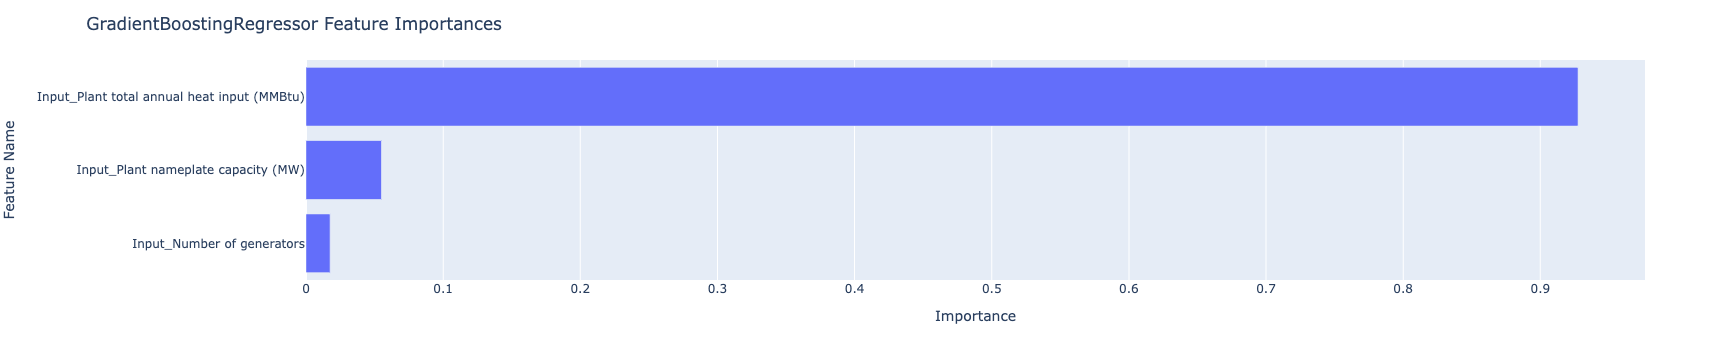

In [34]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=600,
    height=300,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [35]:
df_gb

Feature Name  Importance
2  Input_Plant total annual heat input (MMBtu)    0.927504
1          Input_Plant nameplate capacity (MW)    0.054919
0                   Input_Number of generators    0.017577

In [36]:
df_zero.index = ["_".join(f.split("_")[1:]) for f in df_zero.index]

In [37]:
df_zero

Input_Number of generators                     785
Input_Plant nameplate capacity (MW)             85
Input_Plant total annual heat input (MMBtu)     66
Output_Plant annual net generation (MWh)         0
dtype: int64

In [38]:
df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on="Feature Name", right_on="index")
df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
df_merged

Feature Name  Importance  \
0  Input_Plant total annual heat input (MMBtu)    0.927504   
1          Input_Plant nameplate capacity (MW)    0.054919   
2                   Input_Number of generators    0.017577   

                                         index  Zero_Count  
0  Input_Plant total annual heat input (MMBtu)          66  
1          Input_Plant nameplate capacity (MW)          85  
2                   Input_Number of generators         785

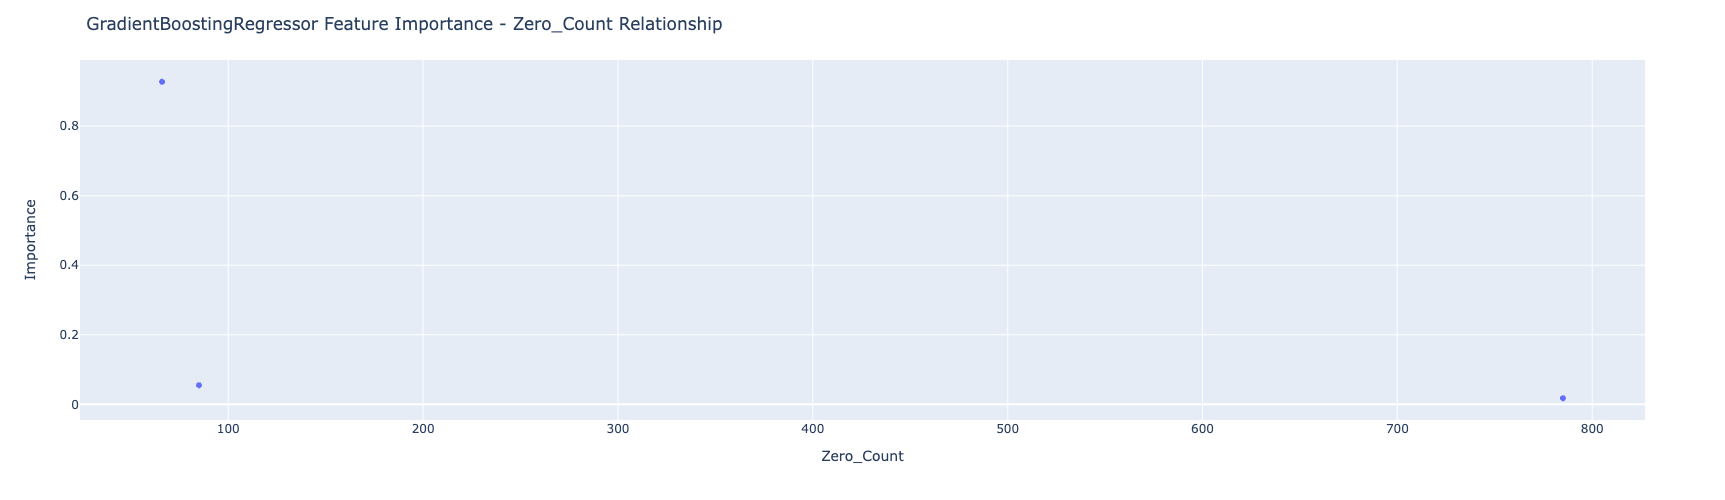

In [39]:
fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
)

fig.show()

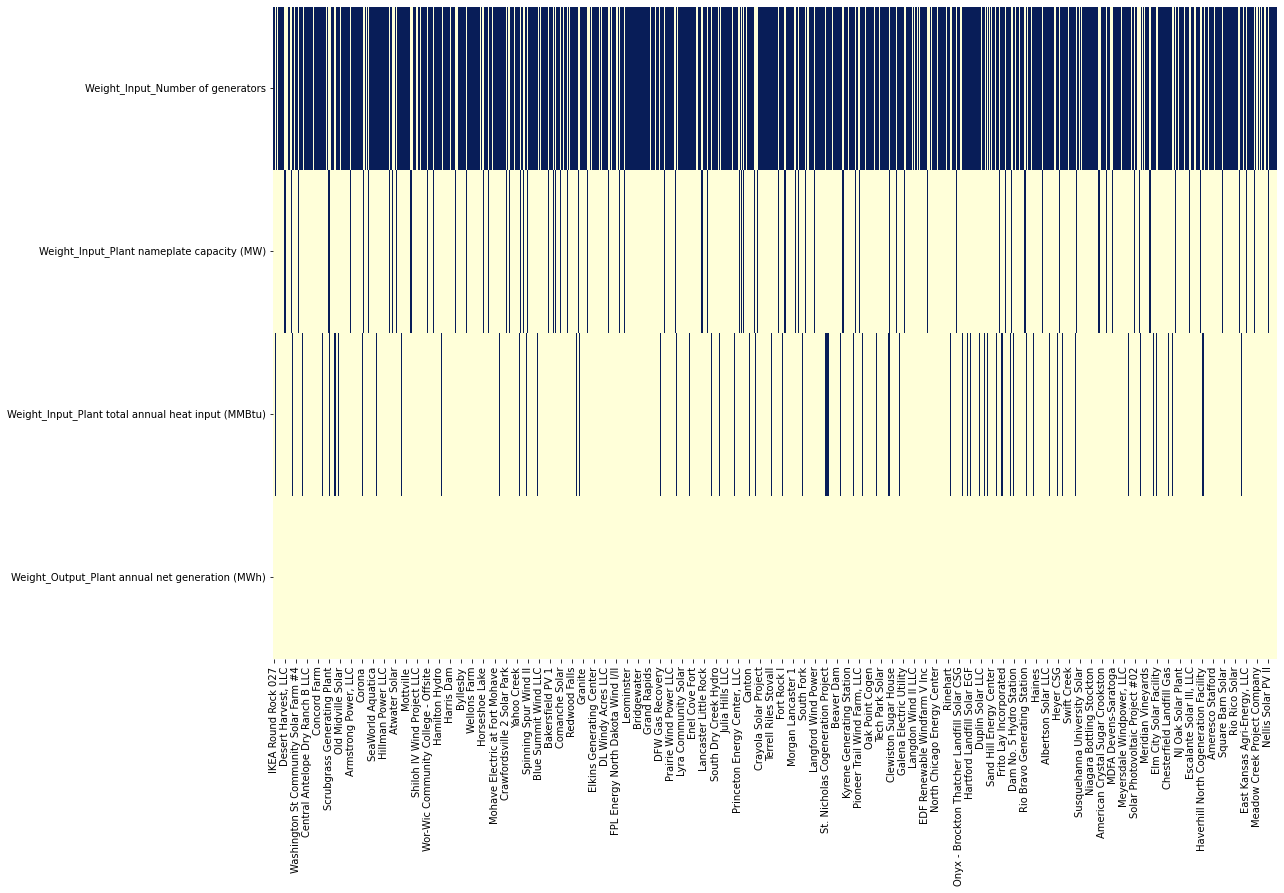

In [40]:
plt.figure(figsize=(18,12))
sns.heatmap(df_weights.eq(0).transpose(),
        cmap="YlGnBu",
        cbar=False,
        cbar_kws={'label': 'Zero Values'});

In [41]:
results 

[(0,
  'gradientboostingregressor',
  ['Input_Plant total annual heat input (MMBtu)',
   'Input_Plant nameplate capacity (MW)',
   'Input_Number of generators'],
  {'r2': 0.9034668763532892,
   'neg_root_mean_squared_error': -71544.48936931038})]

In [42]:
deasolver(inputfile="Data/RealData/eGrid/recent/egrid2020_data_copy.xlsx", folder = "Data/RealData/eGrid/recent/", out_suffix1="_Sol_1", input_imp = results[0])

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [43]:
df_weights_1 = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_Sol_1.xlsx", index_col = 0).iloc[:, 1:]
df_weights_1

Weight_Input_Number of generators  \
IKEA Round Rock 027                                        1.288926e-04   
UNH 7.9 MW Plant                                           3.995732e-06   
Wheelabrator Bridgeport                                    1.277713e-07   
Cantua Solar Station                                       2.690233e-06   
Minco Wind III, LLC                                        2.898244e-07   
...                                                                 ...   
Cirrus Solar LLC                                           1.374344e-05   
Lafayette 2 - Internal Services Dept                       2.071294e-04   
Decorative Panels Intl                                     2.288863e-05   
Hurteau Solar Project Hybrid                               5.357248e-05   
Galloway Landfill                                          1.434864e-04   

                                      Weight_Input_Plant nameplate capacity (MW)  \
IKEA Round Rock 027                                                 1.288926e-04   
UNH 7.9 MW Plant                                                    3.995732e-06   
Wheelabrator Bridgeport                                             1.277713e-07   
Cantua Solar Station                                                2.690233e-06   
Minco Wind III, LLC                                                 2.898244e-07   
...                                                                          ...   
Cirrus Solar LLC                                                    1.374344e-05   
Lafayette 2 - Internal Services Dept                                2.071294e-04   
Decorative Panels Intl                                              2.288863e-05   
Hurteau Solar Project Hybrid                                        5.357248e-05   
Galloway Landfill                                                   1.434864e-04   

                                      Weight_Input_Plant total annual heat input (MMBtu)  \
IKEA Round Rock 027                                                        1.288926e-04    
UNH 7.9 MW Plant                                                           3.995732e-06    
Wheelabrator Bridgeport                                                    1.277713e-07    
Cantua Solar Station                                                       2.690233e-06    
Minco Wind III, LLC                                                        2.898244e-07    
...                                                                                 ...    
Cirrus Solar LLC                                                           1.374344e-05    
Lafayette 2 - Internal Services Dept                                       2.071294e-04    
Decorative Panels Intl                                                     2.288863e-05    
Hurteau Solar Project Hybrid                                               5.357248e-05    
Galloway Landfill                                                          1.434864e-04    

                                      Weight_Output_Plant annual net generation (MWh)  
IKEA Round Rock 027                                                      6.574475e-06  
UNH 7.9 MW Plant                                                         2.038119e-07  
Wheelabrator Bridgeport                                                  6.517281e-09  
Cantua Solar Station                                                     1.372218e-07  
Minco Wind III, LLC                                                      1.478319e-08  
...                                                                               ...  
Cirrus Solar LLC                                                         7.010171e-07  
Lafayette 2 - Internal Services Dept                                     1.056513e-05  
Decorative Panels Intl                                                   1.167490e-06  
Hurteau Solar Project Hybrid                                             2.732593e-06  
Galloway Landfill                                      

In [44]:
df_zero =(df_weights_1==0).sum()
df_zero

Weight_Input_Number of generators                     26
Weight_Input_Plant nameplate capacity (MW)             2
Weight_Input_Plant total annual heat input (MMBtu)     0
Weight_Output_Plant annual net generation (MWh)        0
dtype: int64

In [45]:
df_es = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_Sol.xlsx", index_col = 0).iloc[:, :1]
df_es_1 = pd.read_excel("Data/RealData/eGrid/recent/egrid2020_data_copy_Sol_1.xlsx", index_col = 0).iloc[:, :1]

In [46]:
es = (df_es.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es}")

count of efficient units : 4


In [47]:
es_1 = (df_es_1.Efficiency_Scores==1).sum()
print(f"count of efficient units : {es_1}")

count of efficient units : 1


In [9]:
def ml(df=df, sol_filepath="Data/Deneme/Deneme_Sol_0.xlsx", i=None):
    
    df_sol = pd.read_excel(sol_filepath, index_col = 0)[['Efficiency_Scores']]
    df_weights = pd.read_excel(sol_filepath, index_col = 0).iloc[:, 1:]
    
    df_zero = (df_weights==0).sum()
    print("df_zero: \n", df_zero)
    
    total_zeros = (df_weights==0).sum().sum()
    print("Total Zeros: ", total_zeros)
    
    plt.figure(figsize=(18,12))
    sns.heatmap(df_weights.eq(0).transpose(),
            cmap="YlGnBu",
            cbar=False,
            cbar_kws={'label': 'Zero Values'});
    
    X = df
    y = df_sol
    
    std_scaler = StandardScaler()
    mm_scaler = MinMaxScaler()
    
    gb_model = GradientBoostingRegressor(random_state=42)

    pipe_gb = make_pipeline(std_scaler, gb_model)

    # cross-validate the pipeline
    print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
    print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
    print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())
    
    learning_rate = [1, 0.5, 0.1,  0.01]
    n_estimators = [50, 100, 200, 500, 1000, 2000]
    max_depth = [3, 5, 10, None]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 20, 30]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    subsample = [0.3, 0.5, 0.75, 1.0]
    
    # specify parameter values to search
    params = {}
    params['gradientboostingregressor__learning_rate'] = learning_rate
    params['gradientboostingregressor__n_estimators'] = n_estimators
    params['gradientboostingregressor__max_depth'] = max_depth
    params['gradientboostingregressor__min_samples_split'] = min_samples_split
    params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
    params['gradientboostingregressor__subsample'] = subsample
    
    grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
    grid.fit(X, y.values.ravel())
    
    print("grid.best_score: ", grid.best_score_)
    print("grid.best_params: ", grid.best_params_)
    print("grid.best_estimator: ", grid.best_estimator_)
    print("grid.r2: ", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())
    
    imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
    df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
    input_imp = list(df_gb.loc[df_gb["Feature Name"].str.contains("Input"), "Feature Name"].values)
    results = (i,
                grid.best_estimator_.steps[1][0], input_imp,
                {"r2" : cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean(),
                "neg_root_mean_squared_error": grid.best_score_,
               "total_zeros": total_zeros},
              )
    
    fig = px.bar(df_gb, x="Importance", y="Feature Name")

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"GradientBoostingRegressor Feature Importances",
        yaxis={'categoryorder':'total ascending'}
    )

    fig.show()
    
    df_zero.index = [f.split('_')[1] for f in df_zero.index]
    
    df_merged = pd.merge(df_gb, df_zero.reset_index(), left_on='Feature Name', right_on='index')
    df_merged.rename(columns = {0: "Zero_Count"}, inplace=True)
    
    df_merged["Iteration"] = i
    
    fig = px.scatter(df_merged[~df_merged["Feature Name"].str.contains("Output")], x="Zero_Count", y="Importance",
                hover_data=["Feature Name"])

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"GradientBoostingRegressor Feature Importance - Zero_Count Relationship",
    )

    fig.show()
    
    return pipe_gb, results, y, df_merged

In [10]:
def plotScatter(res_gb, x, y, colorCol, blueCount, redCount):

    fig = px.scatter(res_gb, x=x, y=y, color = colorCol, color_discrete_map= {True:"blue", False: "red"},
                     hover_data=[x, y, colorCol] + [res_gb.index])


    fig.add_traces(
        list(px.line(x = np.linspace(0.3, 1, num=2), y = np.linspace(0.3, 1, num=2)).select_traces())
    )

    fig.update_traces(line_color='lightgreen', line_width=3)

    fig.update_layout(
        autosize=False,
        width=800,
        height=500,
        title_text=f"Efficiency Scores Comparison (Blue: {blueCount}, Red: {redCount})",
    )

    fig.show()

In [10]:
def compareML(pipe_gb, y, X=df, err_thresh = 3):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = pipe_gb.fit(X_train, y_train.values.ravel())
    prediction = model.predict(X_test)
    
    res = pd.DataFrame()
    res["Prediction"] = pd.Series(prediction.ravel())
    res["Actual"] = y_test.values
    res["Diff"] = res.Prediction - res.Actual
    res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
    res[f"Error_Perc < {err_thresh}"] = np.abs(res["Error_Perc"]) < err_thresh  
    res = res.round(4)
    print("res: ", res)
    
    blue = res[f"Error_Perc < {err_thresh}"].sum()
    print("blue: ", blue)
    red = len(res[f"Error_Perc < {err_thresh}"]) - (res[f"Error_Perc < {err_thresh}"].sum())
    print("red: ", red)
    
    rho, p = stats.spearmanr(res.Prediction, res.Actual)
    print("rho:", rho.round(4)) 
    print("p-Value", p.round(4)) 
    
    plotScatter(res, x="Actual", y="Prediction", colorCol=f"Error_Perc < {err_thresh}",
               blueCount=blue, redCount=red)

In [11]:
def compareES(df_1_path=None, df_0_path=None, df_basic_path="Data/Deneme/Deneme_Sol_0.xlsx", err_thresh = 10):
    
    df_basic = pd.read_excel(df_basic_path, index_col=0)
    df_1 = pd.read_excel(df_1_path, index_col=0)
    
    res_gb = pd.DataFrame()
    res_gb["Efficiency_Scores_Basic"] = df_basic["Efficiency_Scores"]
    res_gb["Efficiency_Scores_ML"] = df_1["Efficiency_Scores"]

    
    res_gb["Diff_Basic"] = res_gb["Efficiency_Scores_Basic"]  - res_gb["Efficiency_Scores_ML"]
    res_gb["Diff_Basic_Perc"] = (res_gb["Diff_Basic"] / res_gb["Efficiency_Scores_Basic"]) * 100 
    res_gb[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_gb["Diff_Basic_Perc"]) < err_thresh
    
    res_gb["Diff_Basic"] = res_gb["Efficiency_Scores_Basic"]  - res_gb["Efficiency_Scores_ML"]
    res_gb["Diff_Basic_Perc"] = (res_gb["Diff_Basic"] / res_gb["Efficiency_Scores_Basic"]) * 100 
    res_gb[f"Diff_Basic_Perc < {err_thresh}"] = np.abs(res_gb["Diff_Basic_Perc"]) < err_thresh
    
    blue = res_gb[f"Diff_Basic_Perc < {err_thresh}"].sum()
    print("blue : ", blue)
    red = len(res_gb[f"Diff_Basic_Perc < {err_thresh}"]) - (res_gb[f"Diff_Basic_Perc < {err_thresh}"].sum())
    print("red : ", red)
    
    res_gb = res_gb.round(4)
    
    plotScatter(res_gb, x="Efficiency_Scores_Basic", y="Efficiency_Scores_ML", colorCol=f"Diff_Basic_Perc < {err_thresh}",
               blueCount=blue, redCount=red)
       
    if df_0_path:
        
        df_0 = pd.read_excel(df_0_path, index_col=0)
        res_gb["Efficiency_Scores_ML_Pr"] = df_0["Efficiency_Scores"]
        
        res_gb["Diff_Previous"] = res_gb["Efficiency_Scores_ML_Pr"]  - res_gb["Efficiency_Scores_ML"]
        res_gb["Diff_Previous_Perc"] = (res_gb["Diff_Previous"] / res_gb["Efficiency_Scores_ML_Pr"]) * 100 
        res_gb[f"Diff_Previous_Perc < {err_thresh}"] = np.abs(res_gb["Diff_Previous_Perc"]) < err_thresh
        
        blue = res_gb[f"Diff_Previous_Perc < {err_thresh}"].sum()
        print("blue : ", blue)
        red = len(res_gb[f"Diff_Previous_Perc < {err_thresh}"]) - (res_gb[f"Diff_Previous_Perc < {err_thresh}"].sum())
        print("red : ", red)
        
        #res_gb = res_gb.round(4)
        
        plotScatter(res_gb, x="Efficiency_Scores_ML_Pr", y="Efficiency_Scores_ML", colorCol=f"Diff_Previous_Perc < {err_thresh}",
               blueCount=blue, redCount=red)


### i=0

In [12]:
i=0

In [13]:
deasolver(inputfile="Data/RealData/jmse_37_Data_V3.xlsx", folder = "Data/RealData/", out_suffix1="_Sol_" + str(i))

Restricted license - for non-production use only - expires 2023-10-25


Restricted license - for non-production use only - expires 2023-10-25


No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No solution
No s

/Users/senol.kurt/Desktop/Projects/Senol/DEA/solver.py:74: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed

df_zero: 
 Weight_Input 01     71
Weight_Input 02     63
Weight_Input 03     63
Weight_Input 04     49
Weight_Input 05     77
Weight_Input 06     28
Weight_Input 07     54
Weight_Input 08     70
Weight_Input 09     43
Weight_Input 10     80
Weight_Input 11     58
Weight_Input 12     72
Weight_Output 01     0
dtype: int64
Total Zeros:  728
neg_mean_squared_error: -0.0008325318301347064
neg_root_mean_squared_error: -0.02822902631856782
r2: -0.008360440710025152
grid.best_score:  -0.029526903675977767
grid.best_params:  {'gradientboostingregressor__subsample': 1.0, 'gradientboostingregressor__n_estimators': 200, 'gradientboostingregressor__min_samples_split': 10, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.01}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=0.01, max

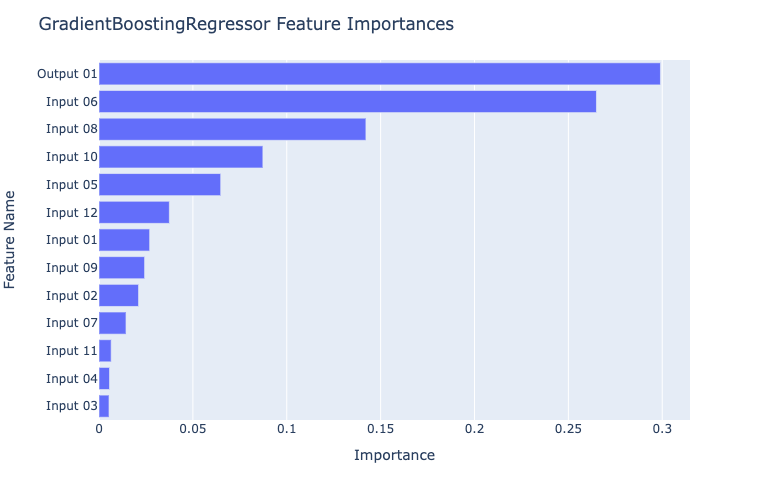

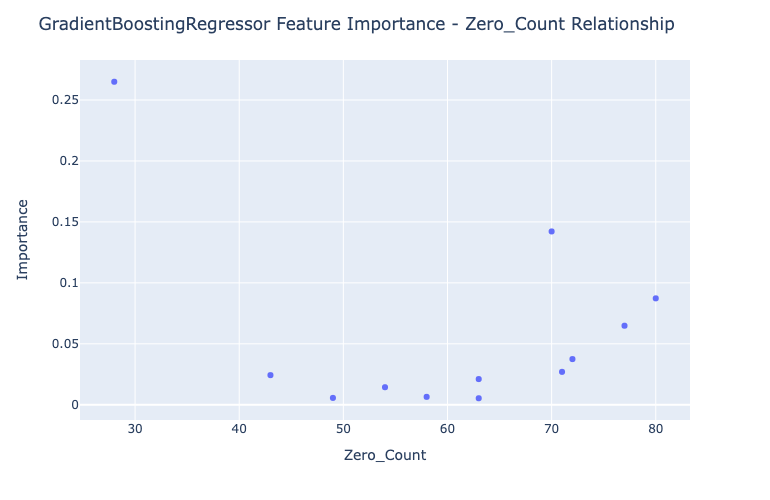

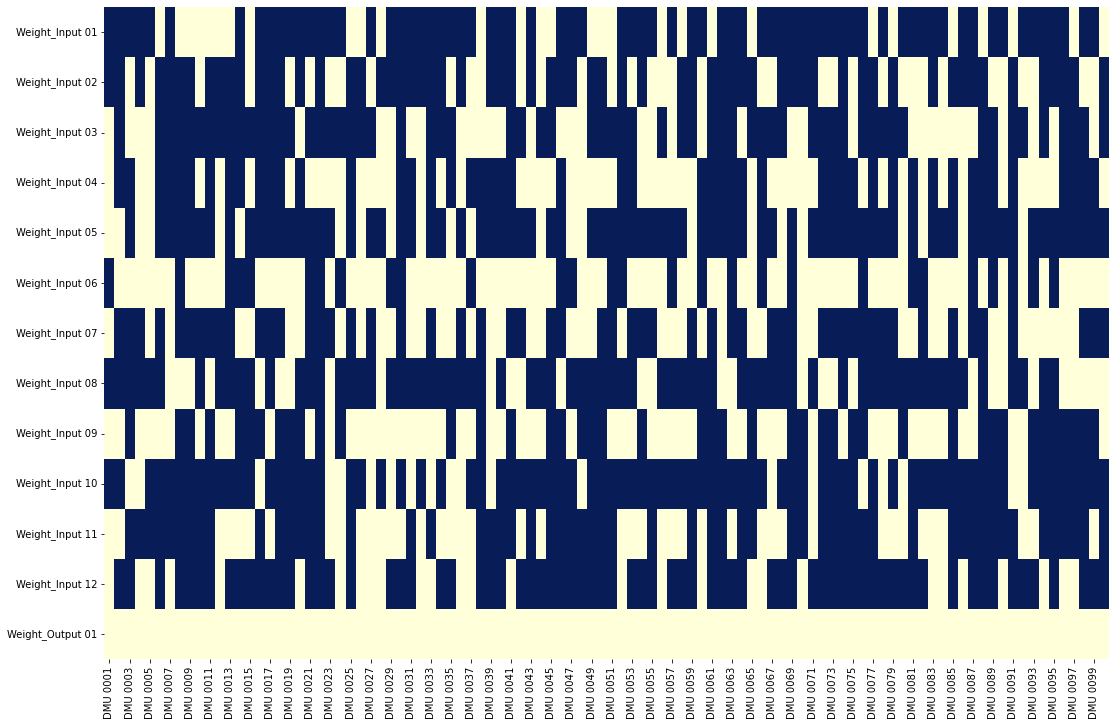

In [18]:
pipe_gb, r, y, df_merged = ml(i=i)
results.append(r)

In [19]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:      Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0       0.9812  0.9339  0.0473      5.0701           False
1       0.9902  1.0000 -0.0098     -0.9782            True
2       0.9749  0.9298  0.0451      4.8507           False
3       0.9839  1.0000 -0.0161     -1.6104            True
4       1.0053  1.0000  0.0053      0.5297            True
5       0.9754  1.0000 -0.0246     -2.4606            True
6       0.8891  0.9366 -0.0475     -5.0764           False
7       0.9953  1.0000 -0.0047     -0.4734            True
8       1.0117  1.0000  0.0117      1.1650            True
9       0.9913  0.9569  0.0344      3.5941           False
10      0.9692  1.0000 -0.0308     -3.0757           False
11      0.9717  0.9517  0.0200      2.0993            True
12      1.0048  1.0000  0.0048      0.4836            True
13      0.9878  0.9630  0.0248      2.5755            True
14      1.0025  1.0000  0.0025      0.2454            True
15      0.9811  0.9300  0.0510      5.4879        

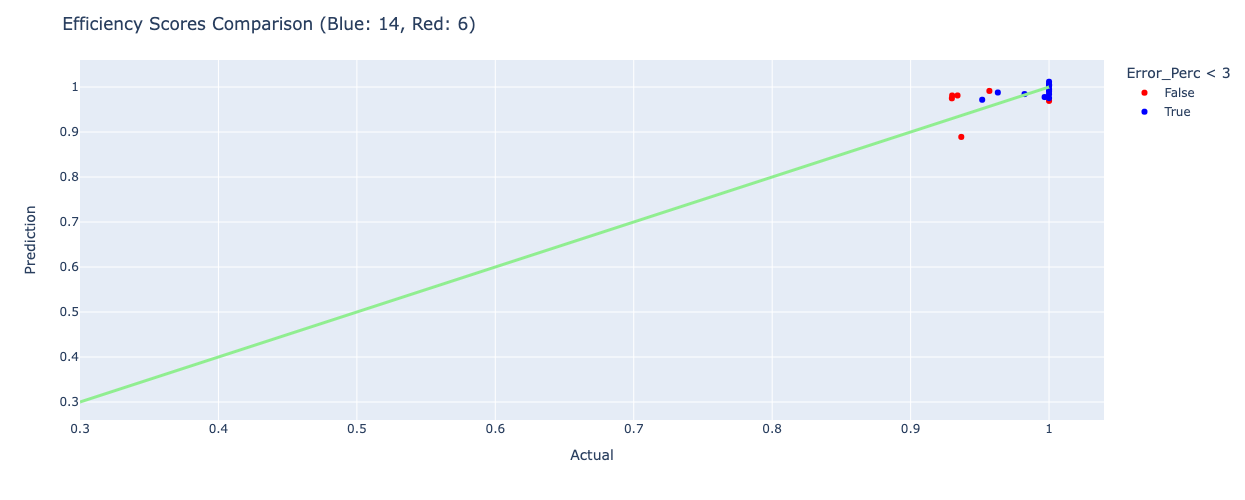

In [21]:
compareML(pipe_gb, y)

### i = 1

In [22]:
i +=1

In [27]:
for r in results[-1:]:
    deasolver(inputfile="Data/Deneme.xlsx", folder = "Data/Deneme/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

20.0
40.0
60.0
80.0
100.0
Solution file saved outputfile


In [25]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Deneme/Deneme_gradientboostingregressor_Sol_1.xlsx", i=i)

results.append(r)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/Deneme/Deneme_gradientboostingregressor_Sol_1.xlsx'

In [18]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7171  0.6779  0.0392      5.7816           False
1        0.7450  0.7397  0.0053      0.7158            True
2        0.5841  0.5786  0.0055      0.9482            True
3        0.7271  0.7492 -0.0221     -2.9509            True
4        0.6222  0.6600 -0.0378     -5.7287           False
..          ...     ...     ...         ...             ...
195      0.4262  0.4118  0.0145      3.5109           False
196      0.6579  0.6580 -0.0001     -0.0169            True
197      0.5183  0.5145  0.0038      0.7422            True
198      0.5408  0.5081  0.0327      6.4305           False
199      0.6626  0.6875 -0.0249     -3.6171           False

[200 rows x 5 columns]
blue:  97
red:  103
rho: 0.9821
p-Value 0.0


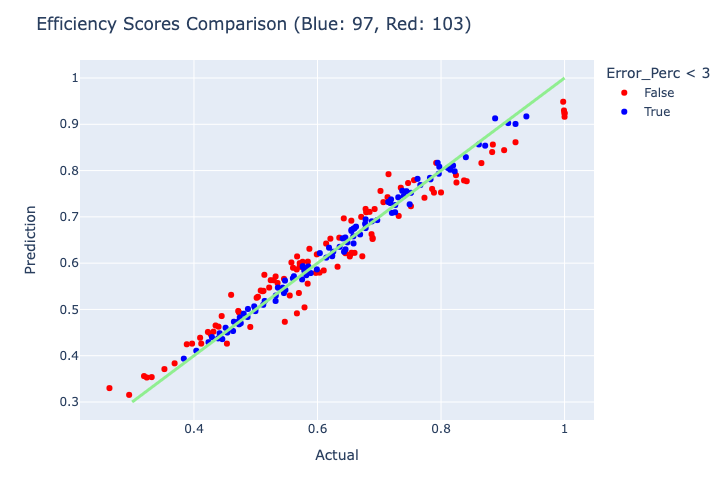

In [36]:
compareML(pipe_gb, y)

blue :  226
red :  774


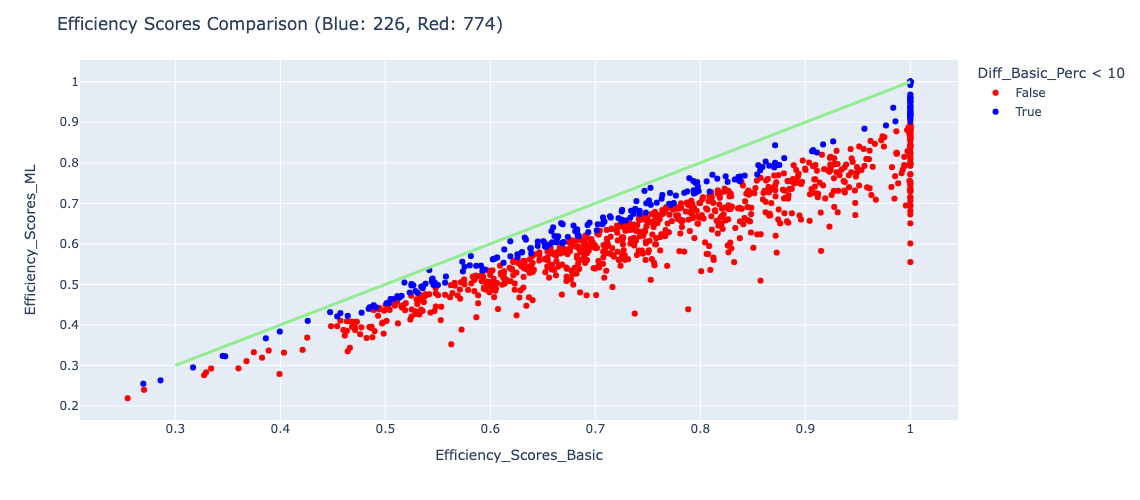

In [39]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_1.xlsx")

### i = 2

In [19]:
i +=1

In [20]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     135
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      61
Weight_Input 05     104
Weight_Input 06      31
Weight_Input 07     248
Weight_Input 08       2
Weight_Input 09     648
Weight_Input 10      96
Weight_Input 11       9
Weight_Input 12     552
Weight_Output 01      0
dtype: int64
Total Zeros:  1887
neg_mean_squared_error: -0.0009590860004778323
neg_root_mean_squared_error: -0.030732585638491516
r2: 0.953312865728765
grid.best_score:  -0.023996854672094076
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

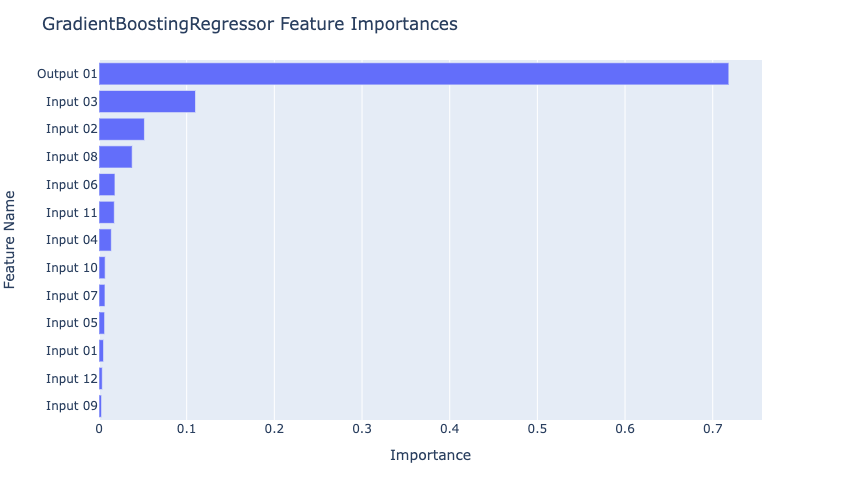

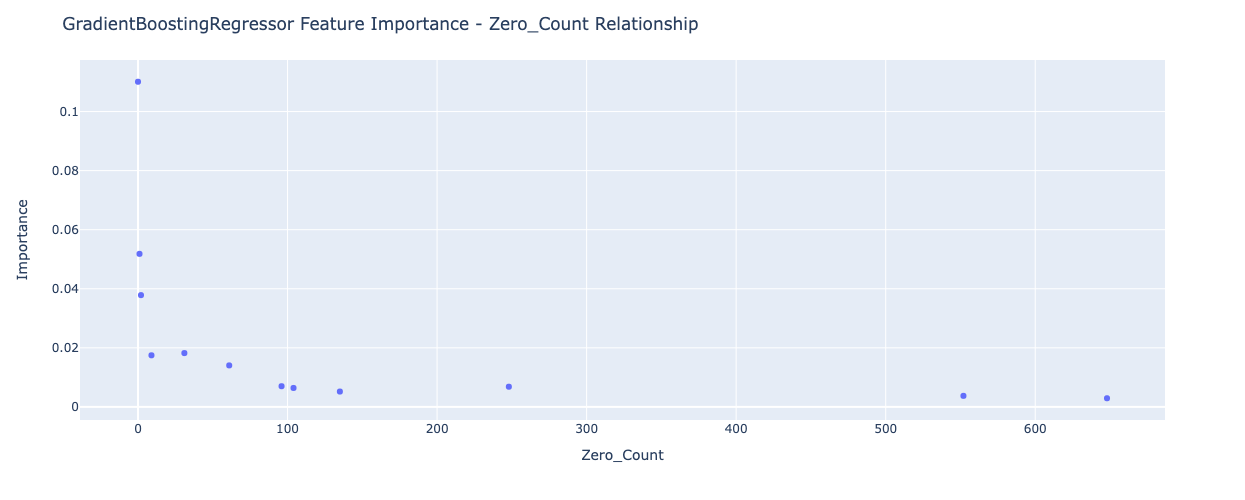

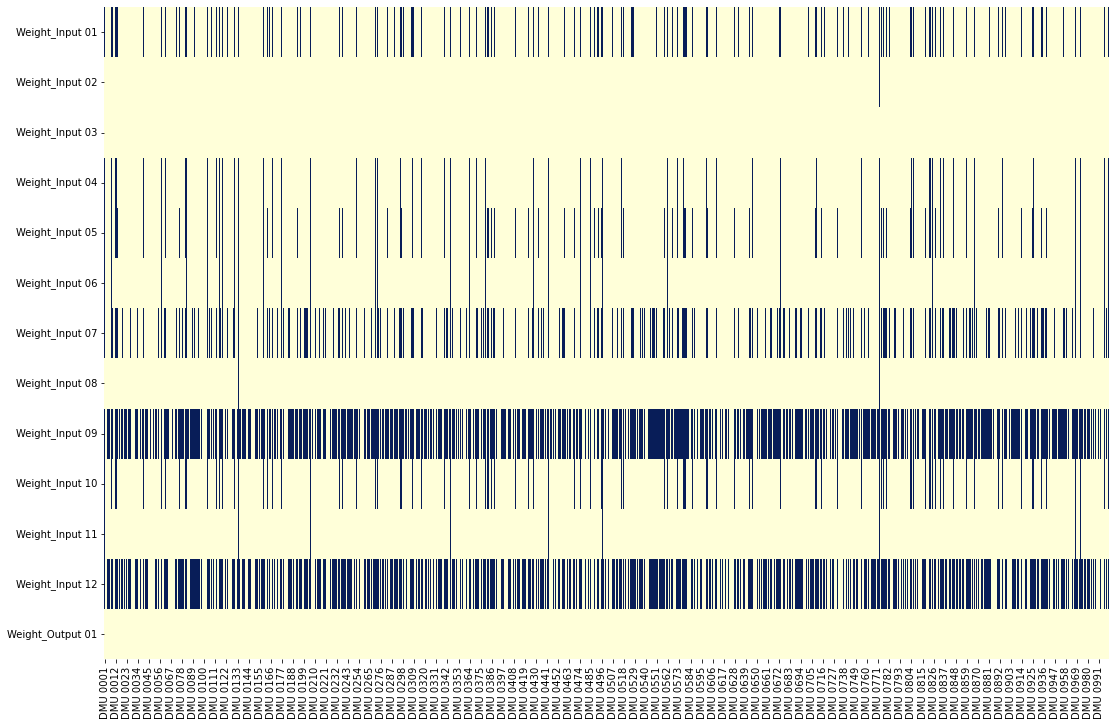

In [42]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_2.xlsx", i=i)
results.append(r)

In [21]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7353  0.6846  0.0506      7.3975           False
1        0.7524  0.7446  0.0078      1.0480            True
2        0.5930  0.5961 -0.0031     -0.5166            True
3        0.7372  0.7526 -0.0154     -2.0524            True
4        0.6296  0.6578 -0.0283     -4.2949           False
..          ...     ...     ...         ...             ...
195      0.4148  0.4047  0.0101      2.4968            True
196      0.6745  0.6706  0.0039      0.5830            True
197      0.5215  0.5139  0.0076      1.4820            True
198      0.5379  0.5270  0.0109      2.0676            True
199      0.6813  0.7135 -0.0322     -4.5183           False

[200 rows x 5 columns]
blue:  102
red:  98
rho: 0.9851
p-Value 0.0


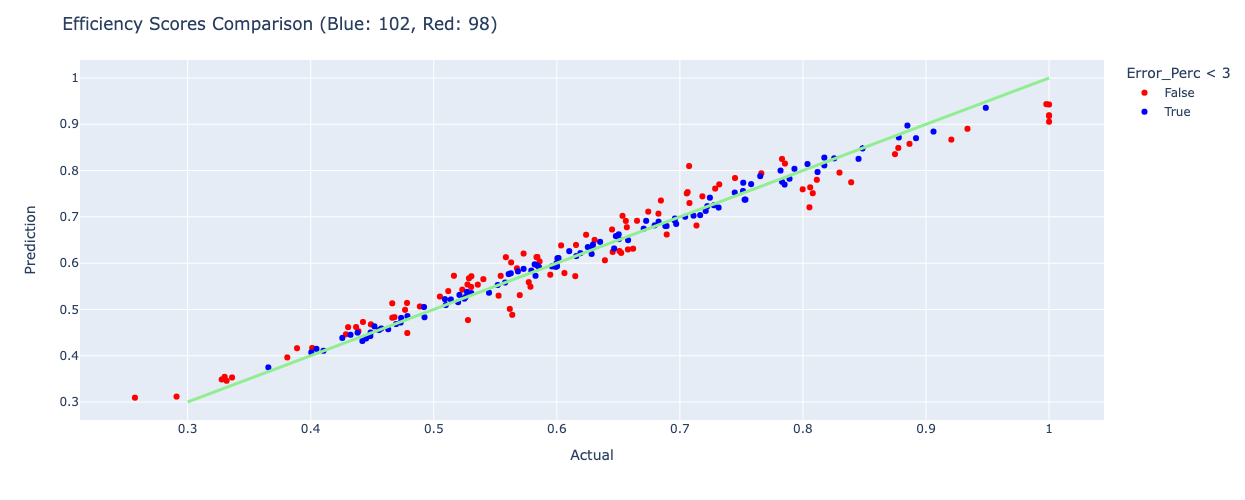

In [45]:
compareML(pipe_gb, y)

blue :  246
red :  754


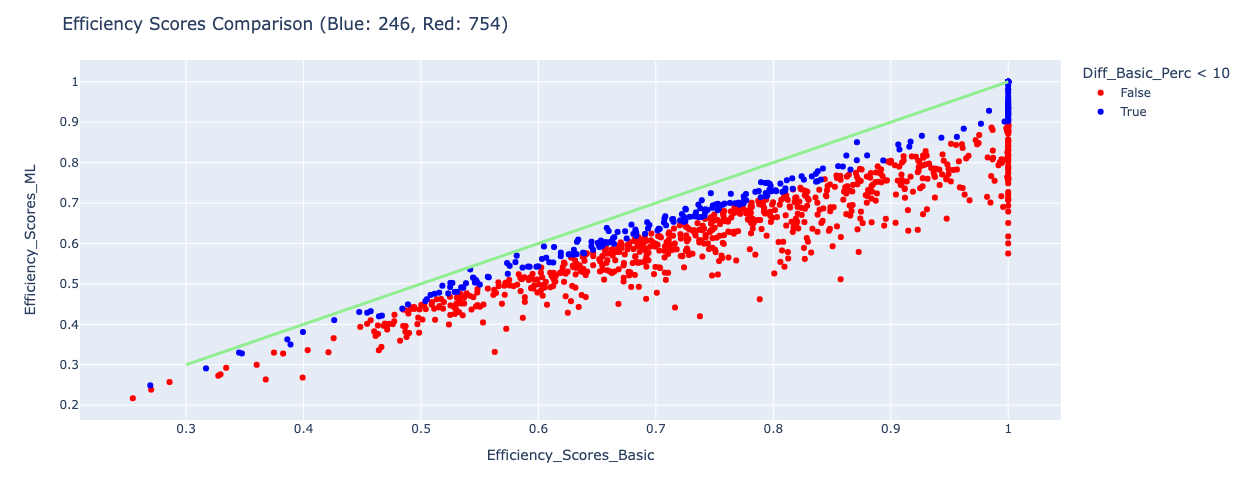

blue :  994
red :  6


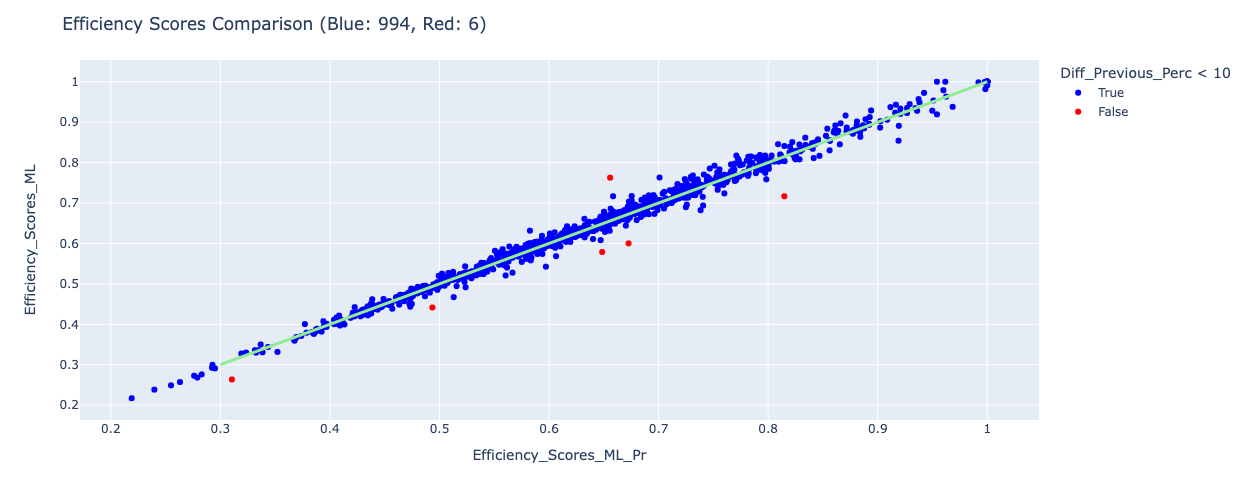

In [46]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_2.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_1.xlsx")

### i = 3

In [22]:
i +=1

In [23]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     174
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      56
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     112
Weight_Input 08       2
Weight_Input 09     695
Weight_Input 10      98
Weight_Input 11      13
Weight_Input 12     580
Weight_Output 01      0
dtype: int64
Total Zeros:  1860
neg_mean_squared_error: -0.0010033813062310234
neg_root_mean_squared_error: -0.03152024302540109
r2: 0.951614979481249
grid.best_score:  -0.02477100716341915
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, mi

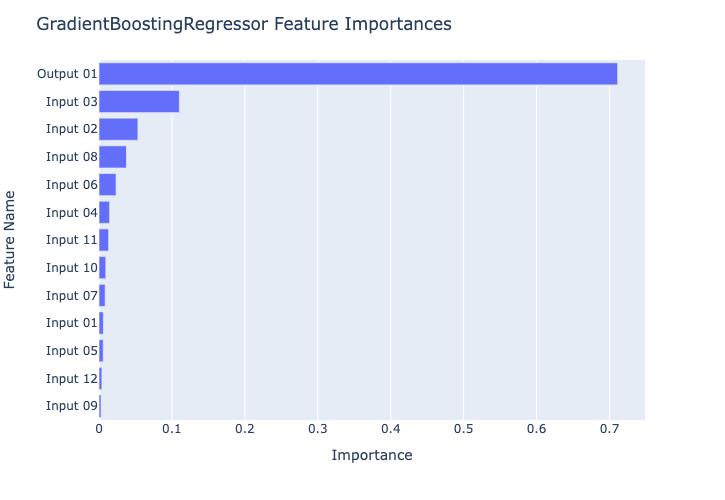

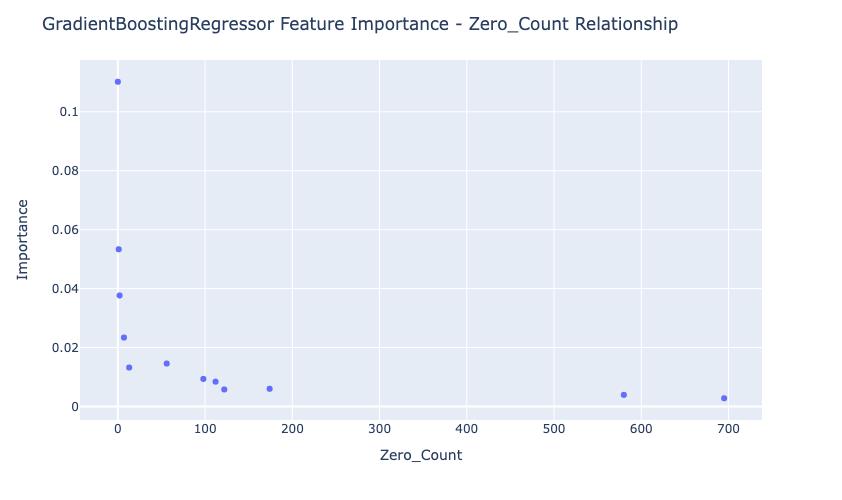

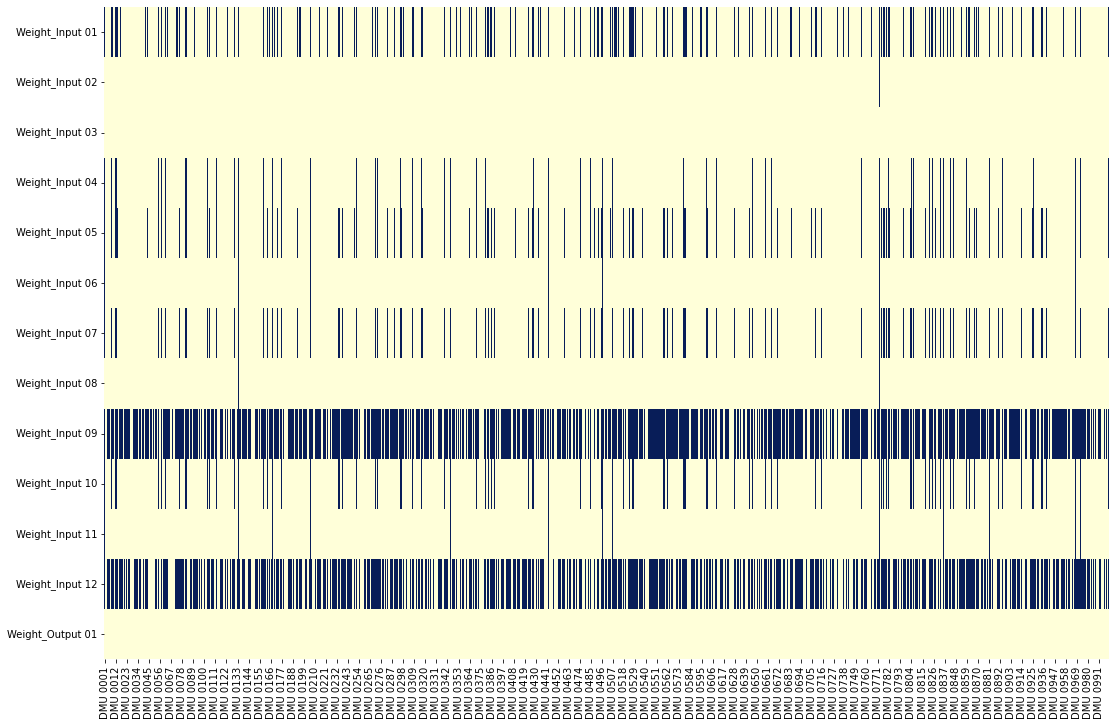

In [50]:
pipe_gb, r, y,df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_3.xlsx", i=i)
results.append(r)

In [24]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7127  0.6850  0.0277      4.0396           False
1        0.7537  0.7446  0.0091      1.2264            True
2        0.5926  0.6035 -0.0109     -1.8050            True
3        0.7312  0.7526 -0.0214     -2.8483            True
4        0.6163  0.6578 -0.0416     -6.3164           False
..          ...     ...     ...         ...             ...
195      0.4145  0.3921  0.0224      5.7129           False
196      0.6656  0.6706 -0.0050     -0.7464            True
197      0.5218  0.5141  0.0077      1.5020            True
198      0.5374  0.5270  0.0104      1.9733            True
199      0.6842  0.7135 -0.0293     -4.1122           False

[200 rows x 5 columns]
blue:  102
red:  98
rho: 0.9863
p-Value 0.0


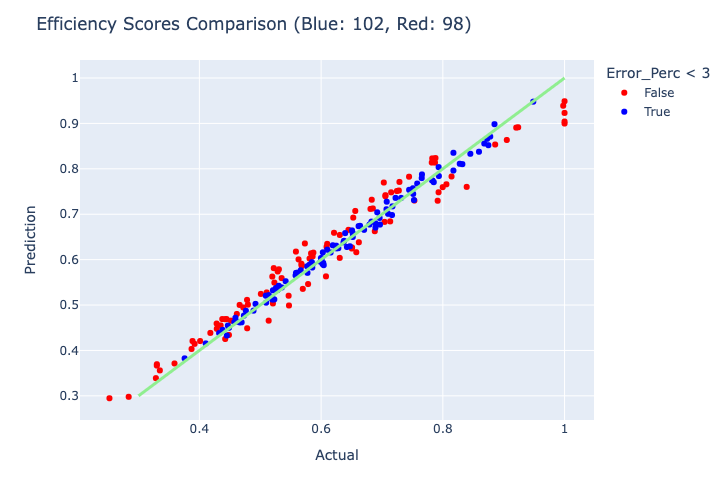

In [52]:
compareML(pipe_gb, y)

blue :  234
red :  766


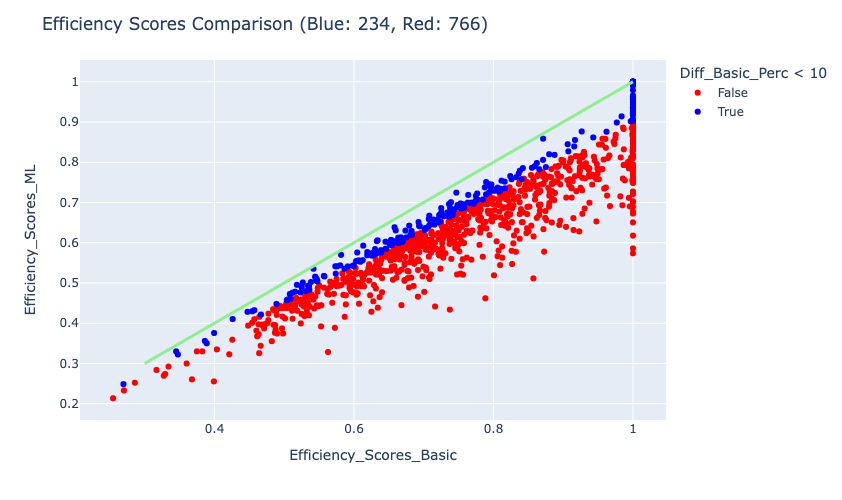

blue :  999
red :  1


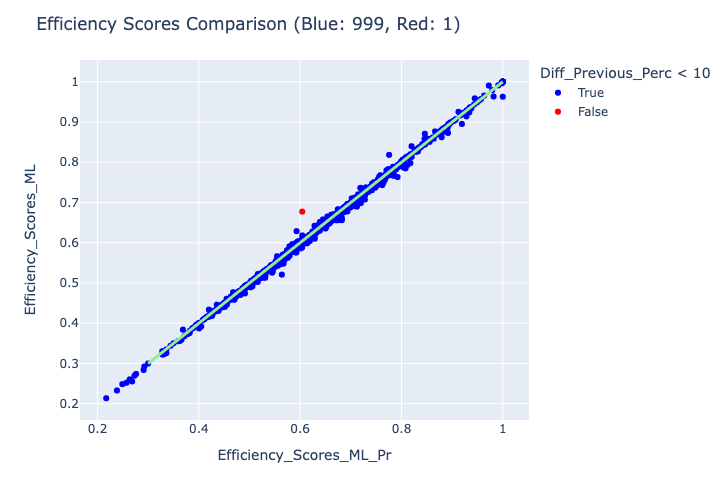

In [54]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_3.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_2.xlsx")

### i = 4

In [25]:
i +=1

In [26]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     124
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     158
Weight_Input 06       7
Weight_Input 07     104
Weight_Input 08       2
Weight_Input 09     682
Weight_Input 10      94
Weight_Input 11      23
Weight_Input 12     569
Weight_Output 01      0
dtype: int64
Total Zeros:  1782
neg_mean_squared_error: -0.0009758604402618377
neg_root_mean_squared_error: -0.03114129226640162
r2: 0.9526329992041557
grid.best_score:  -0.02407577862452921
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, m

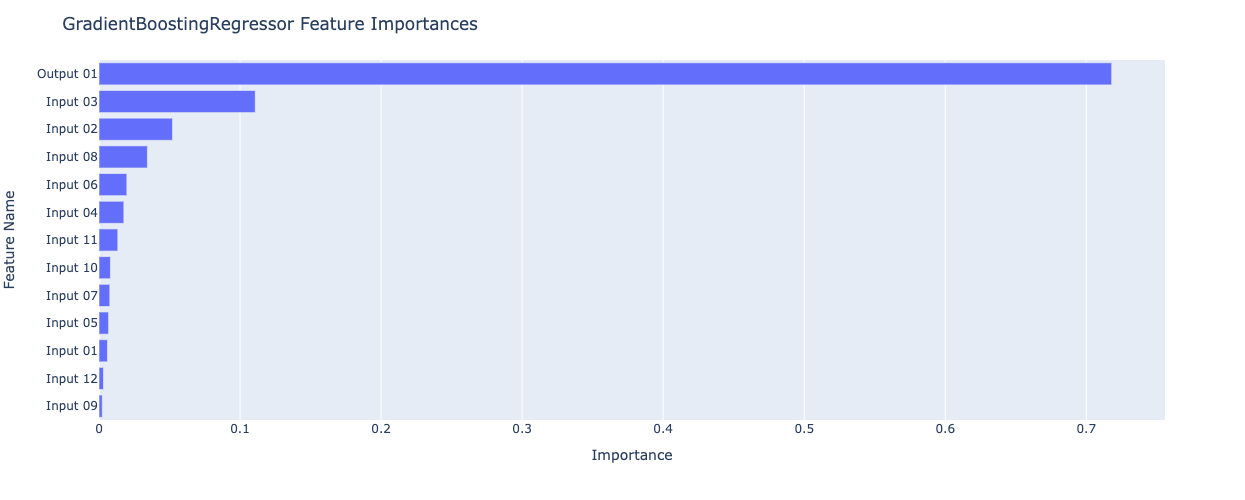

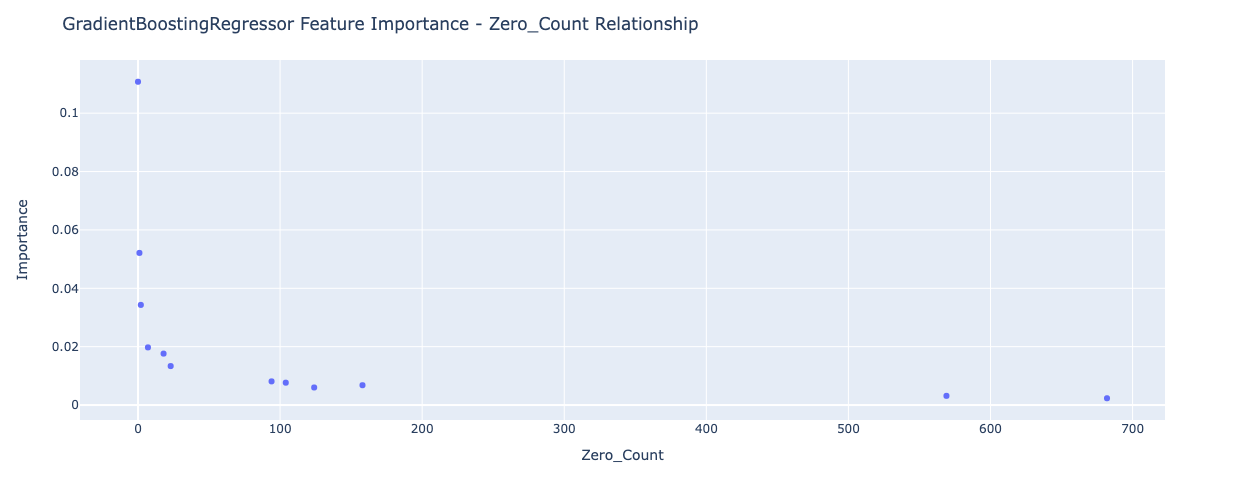

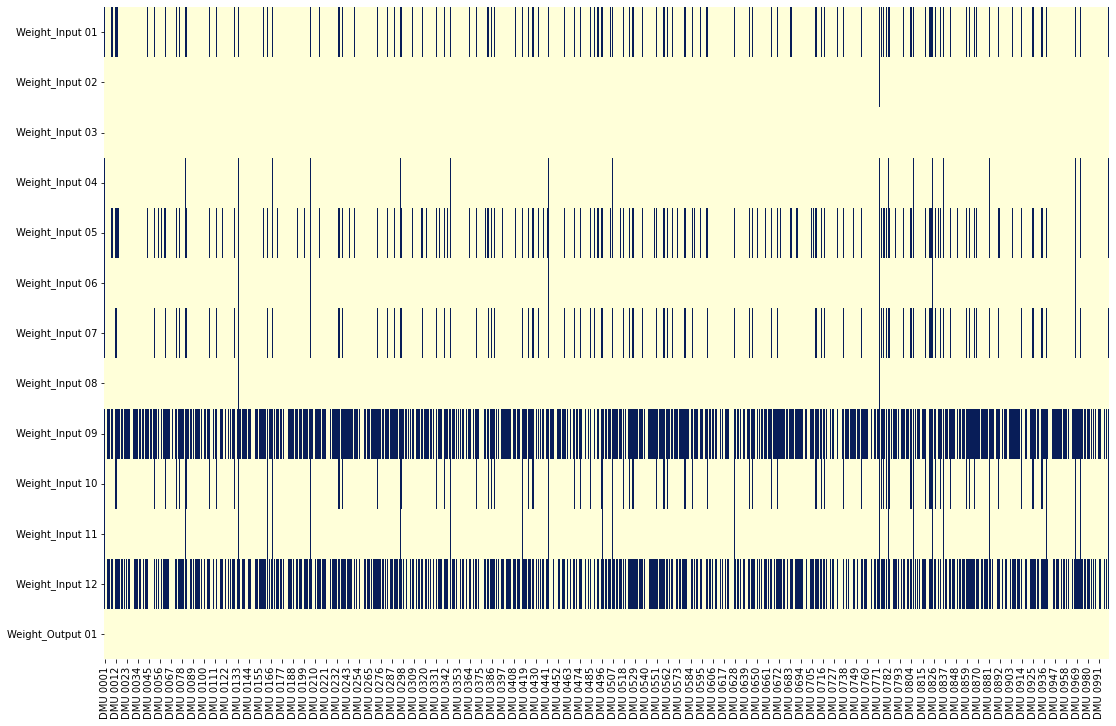

In [57]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_4.xlsx", i=i)
results.append(r)

In [27]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7323  0.6850  0.0473      6.9111           False
1        0.7463  0.7446  0.0017      0.2227            True
2        0.5949  0.5957 -0.0008     -0.1388            True
3        0.7338  0.7526 -0.0189     -2.5084            True
4        0.6266  0.6569 -0.0303     -4.6089           False
..          ...     ...     ...         ...             ...
195      0.4142  0.3921  0.0221      5.6397           False
196      0.6641  0.6706 -0.0064     -0.9606            True
197      0.5241  0.5126  0.0114      2.2319            True
198      0.5373  0.5270  0.0103      1.9514            True
199      0.6805  0.7135 -0.0330     -4.6243           False

[200 rows x 5 columns]
blue:  116
red:  84
rho: 0.9867
p-Value 0.0


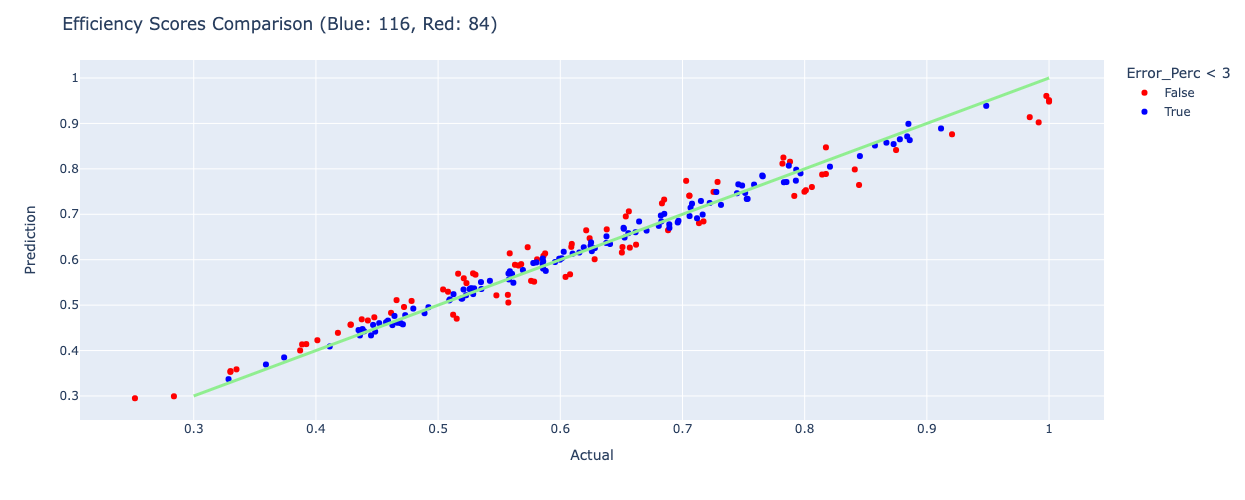

In [59]:
compareML(pipe_gb, y)

blue :  228
red :  772


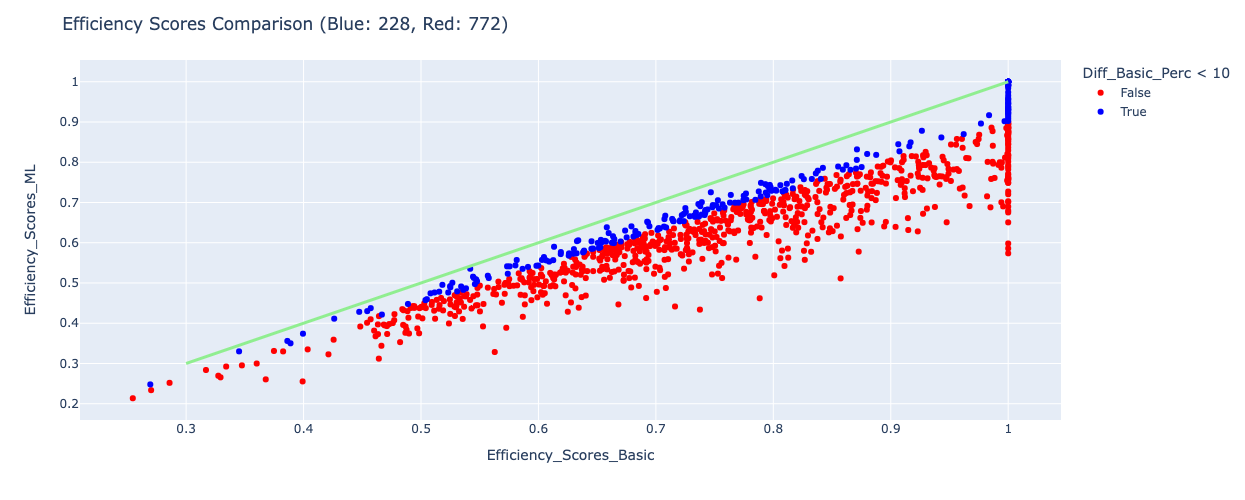

blue :  1000
red :  0


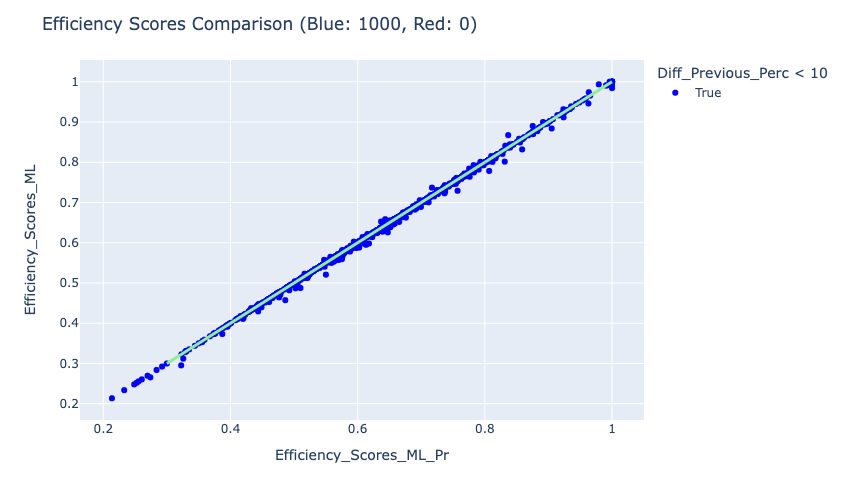

In [60]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_4.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_3.xlsx")

### i = 5

In [28]:
i +=1

In [29]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

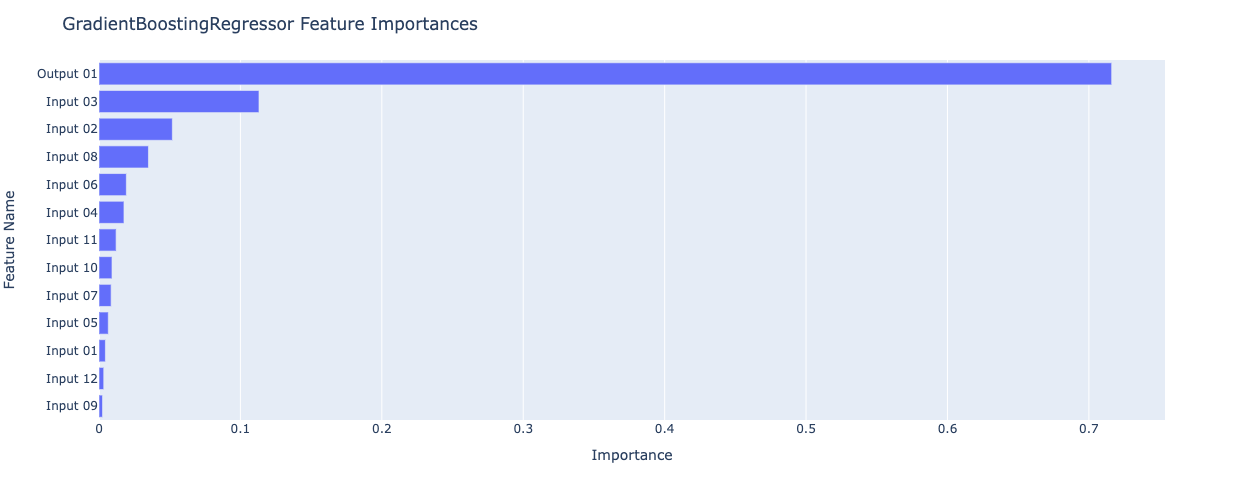

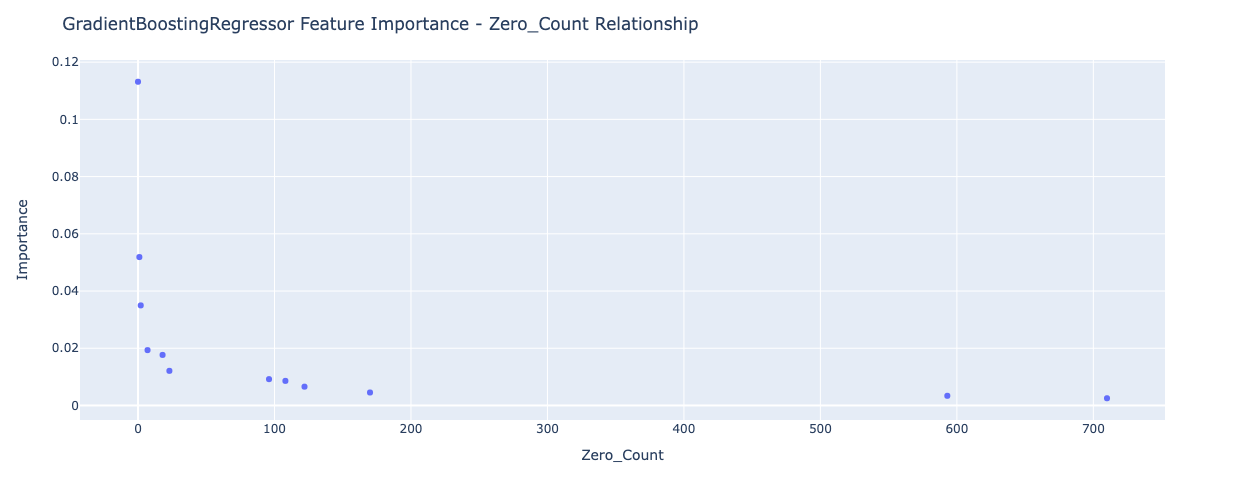

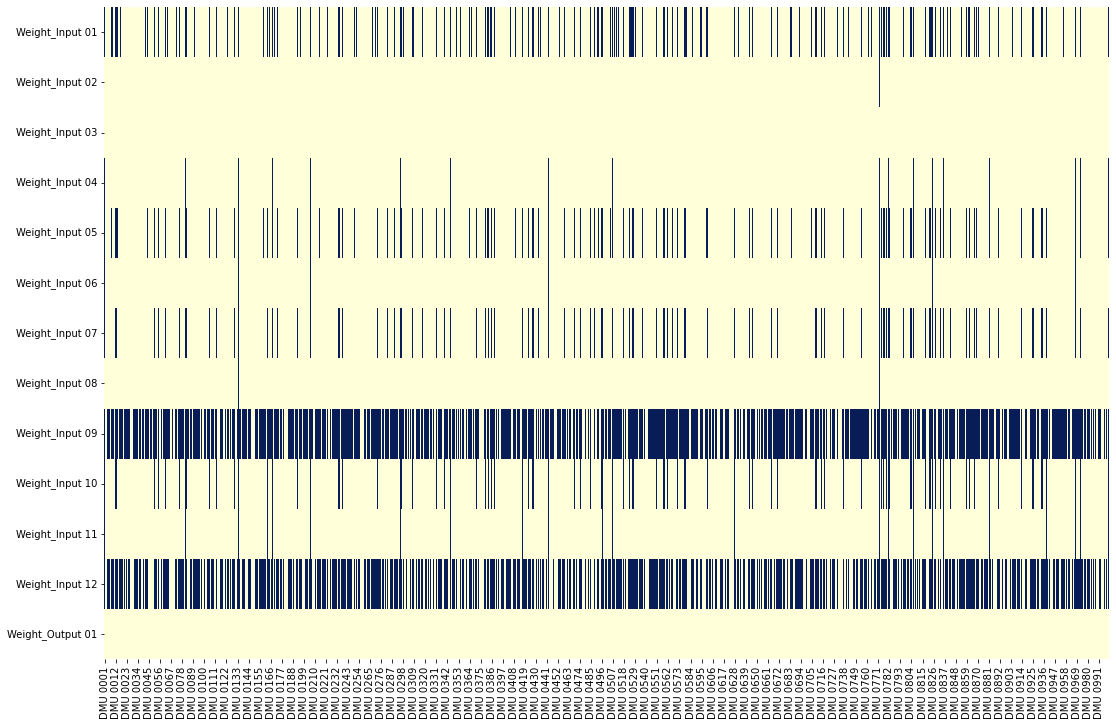

In [63]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_5.xlsx", i=i)
results.append(r)

In [30]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


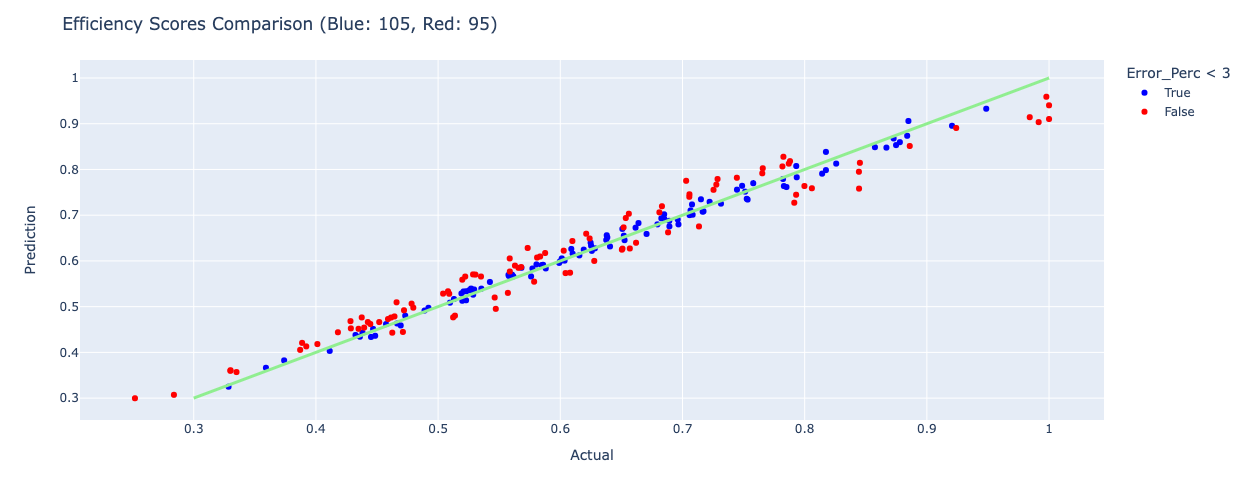

In [65]:
compareML(pipe_gb, y)

blue :  229
red :  771


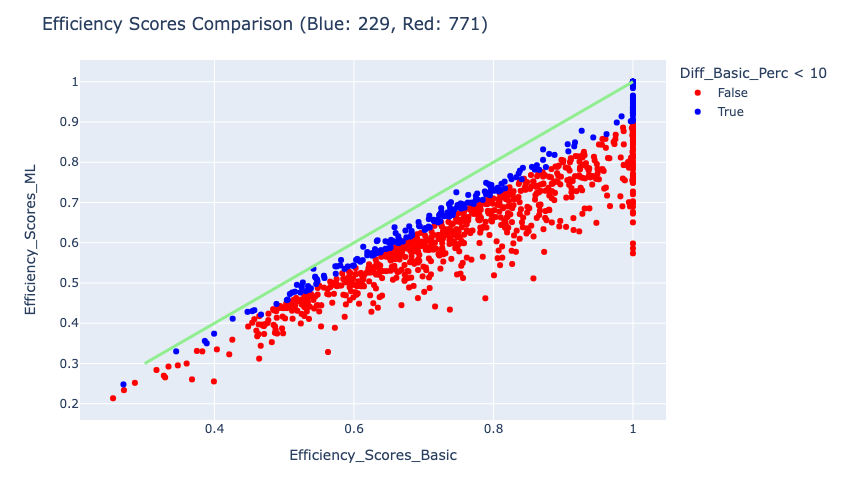

blue :  1000
red :  0


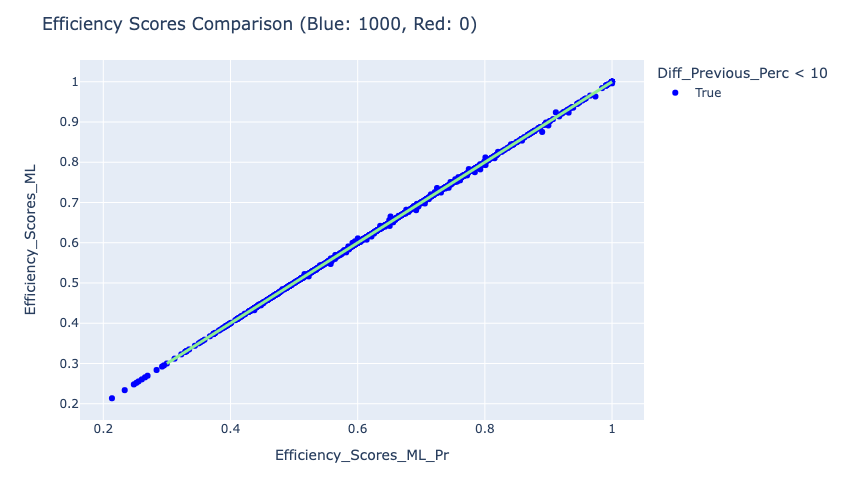

In [66]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_5.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_4.xlsx")

### i = 6

In [31]:
i +=1

In [32]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

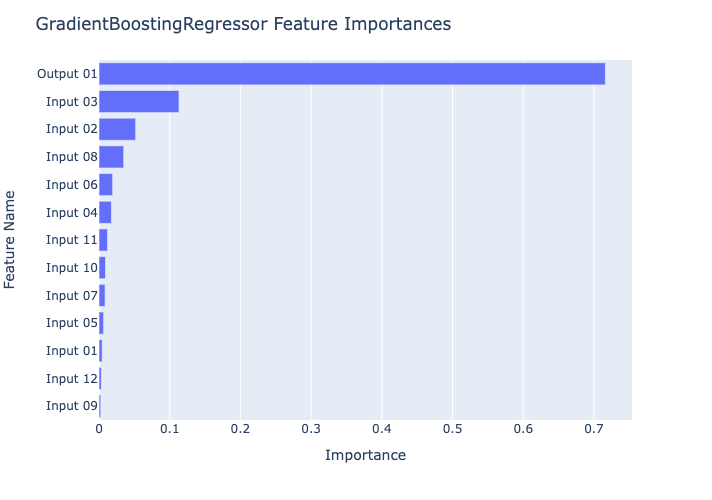

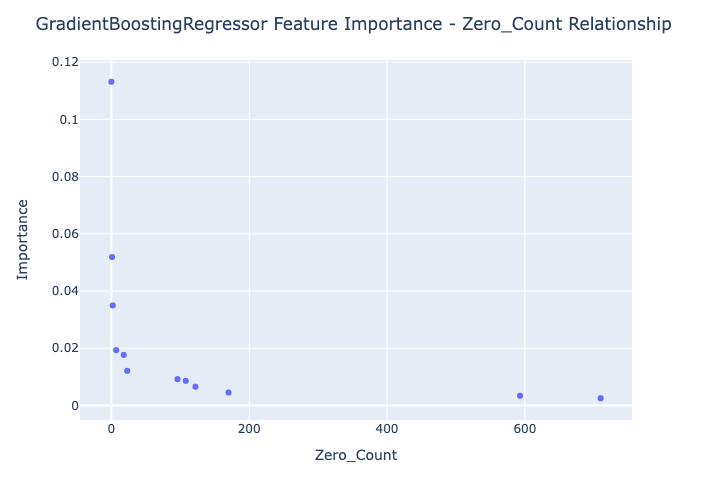

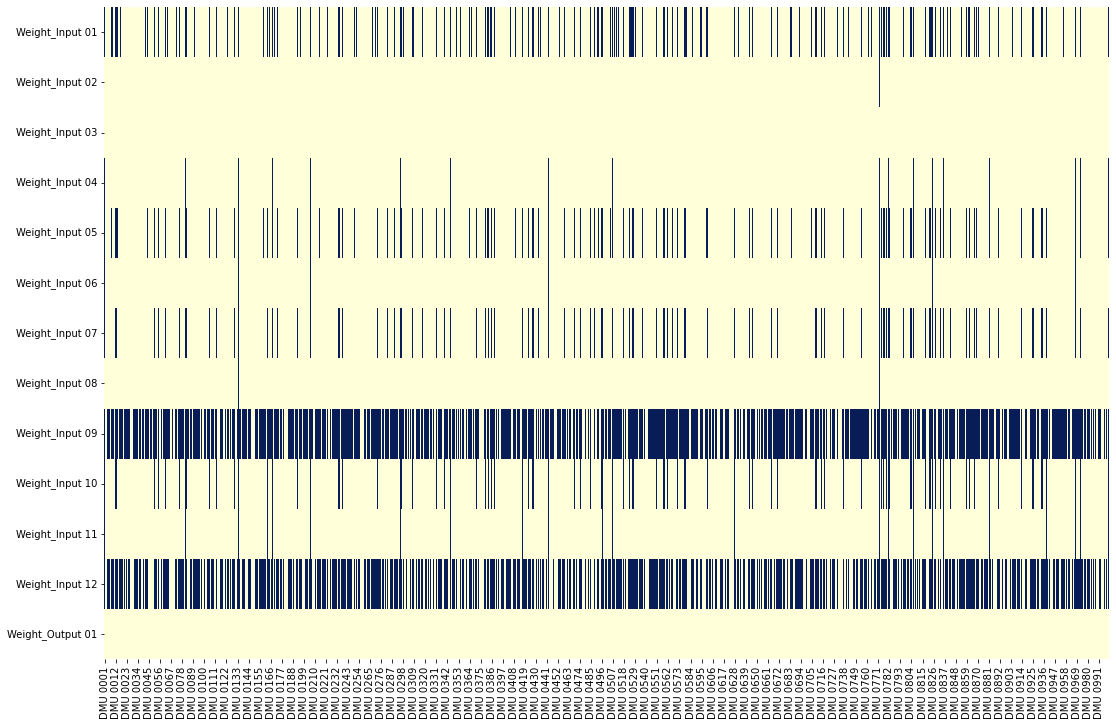

In [69]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_6.xlsx", i=i)
results.append(r)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


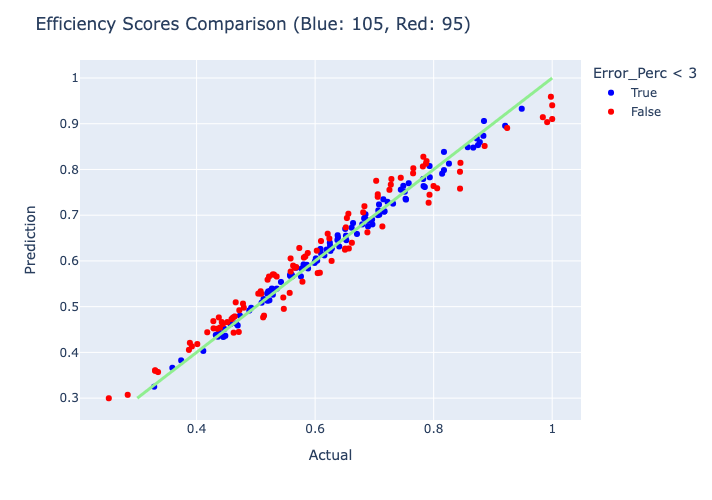

In [70]:
compareML(pipe_gb, y)

In [33]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

blue :  229
red :  771


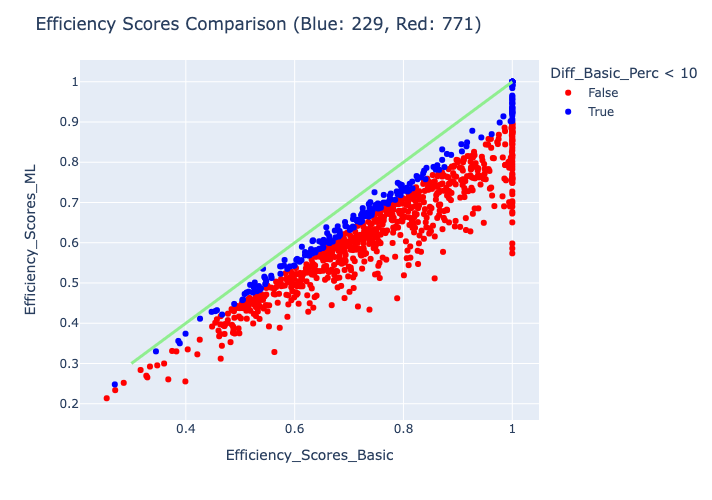

blue :  1000
red :  0


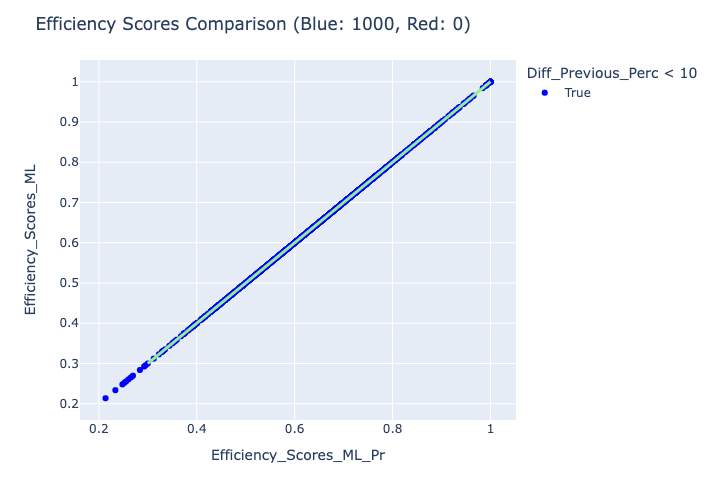

In [72]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_6.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_5.xlsx")

### i = 7

In [34]:
i +=1

In [35]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

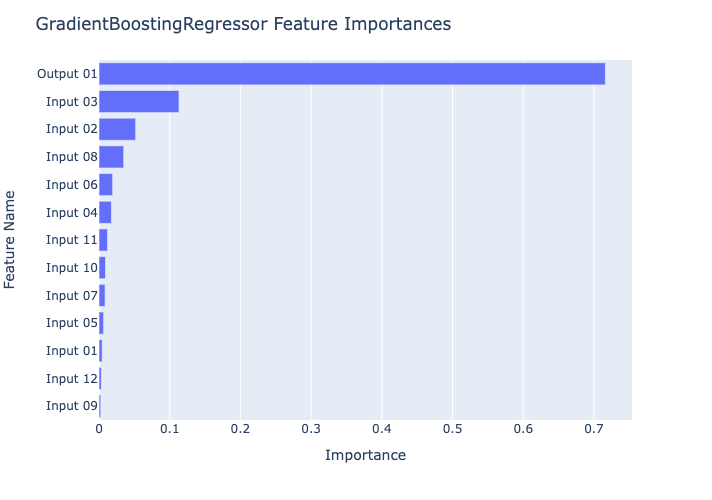

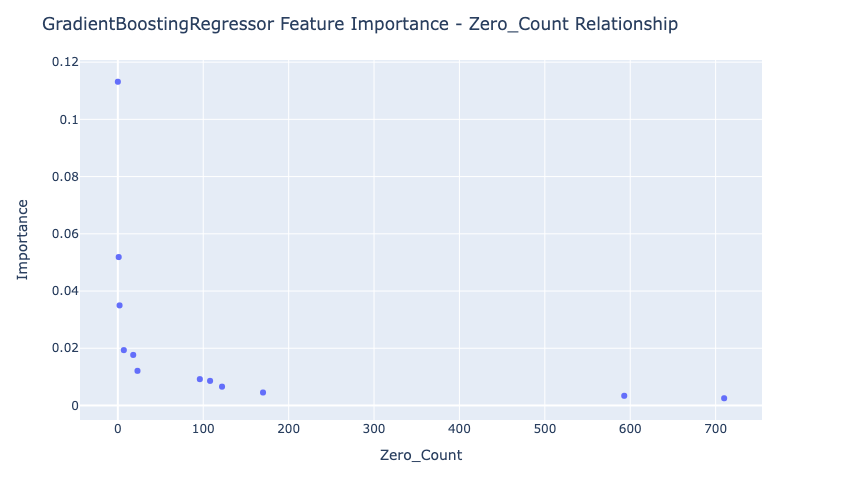

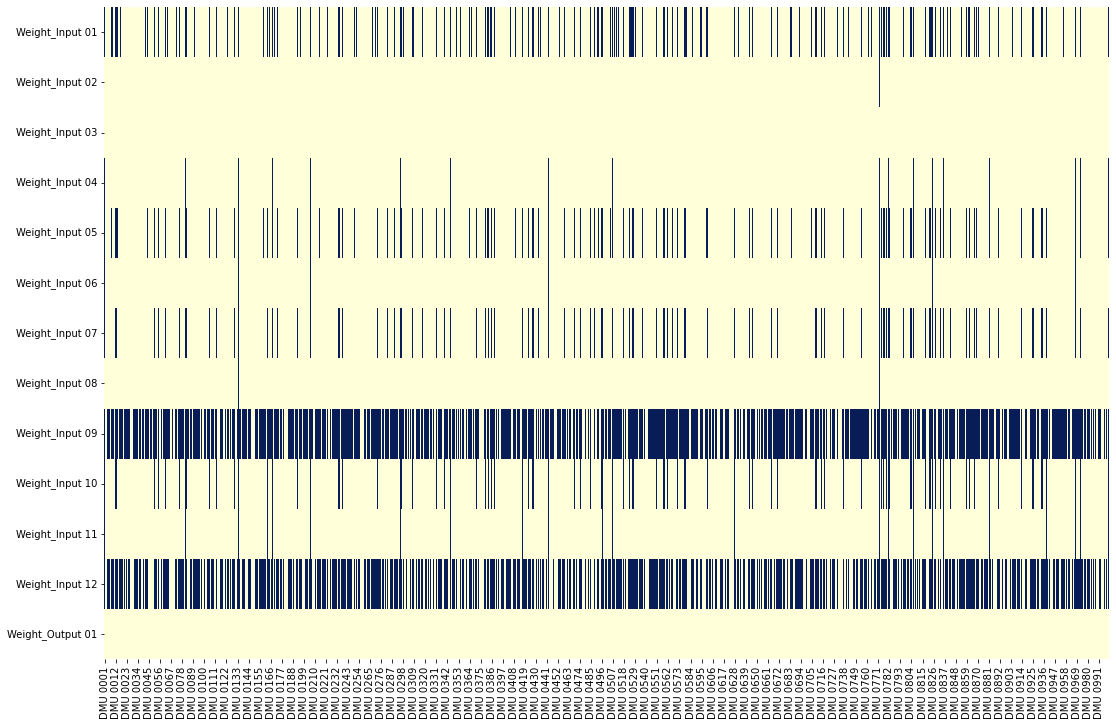

In [75]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_7.xlsx", i=i)
results.append(r)

In [36]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


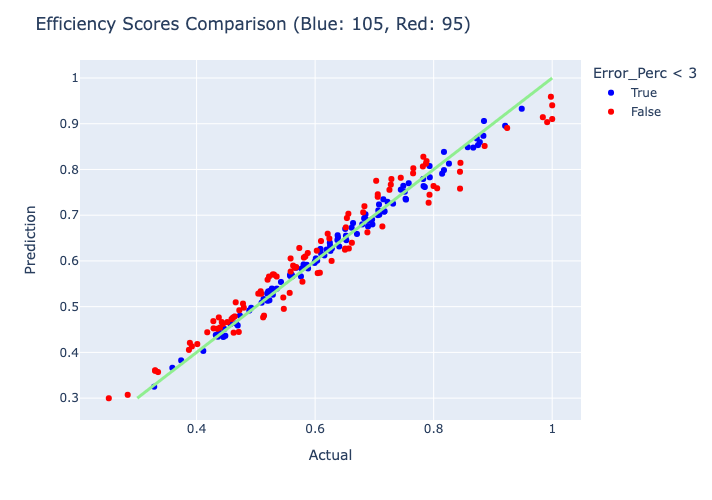

In [77]:
compareML(pipe_gb, y)

blue :  229
red :  771


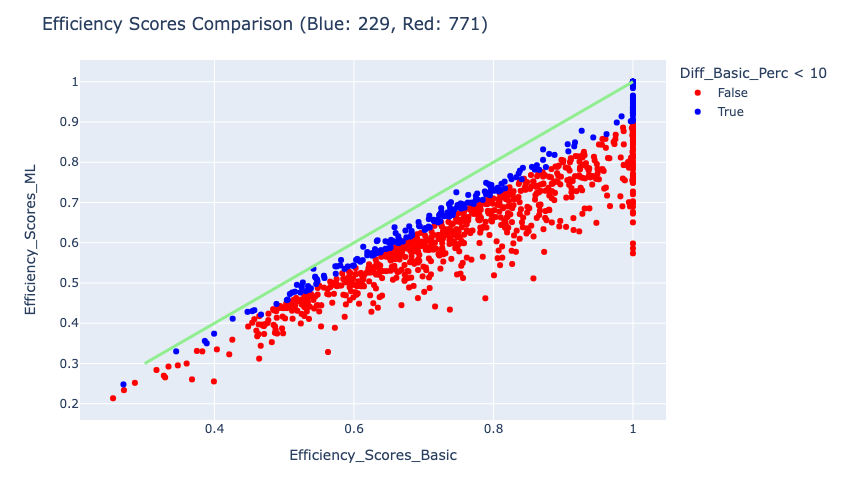

blue :  1000
red :  0


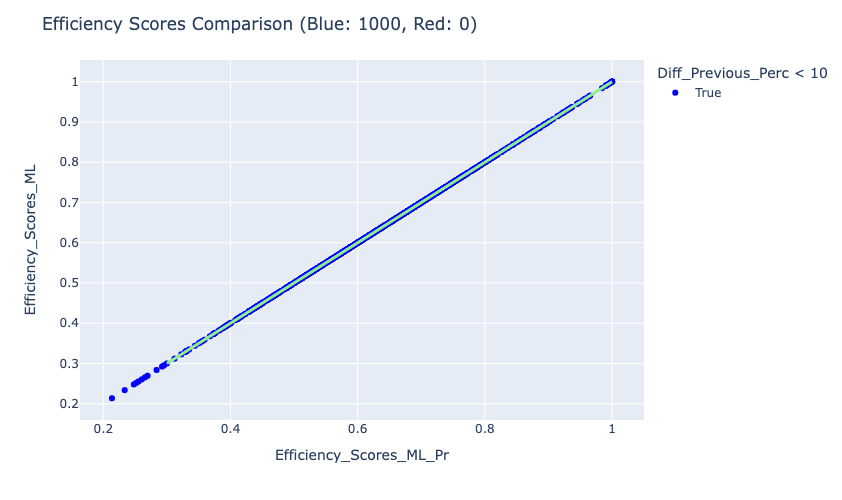

In [78]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_7.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_6.xlsx")

### i = 8

In [37]:
i +=1

In [38]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

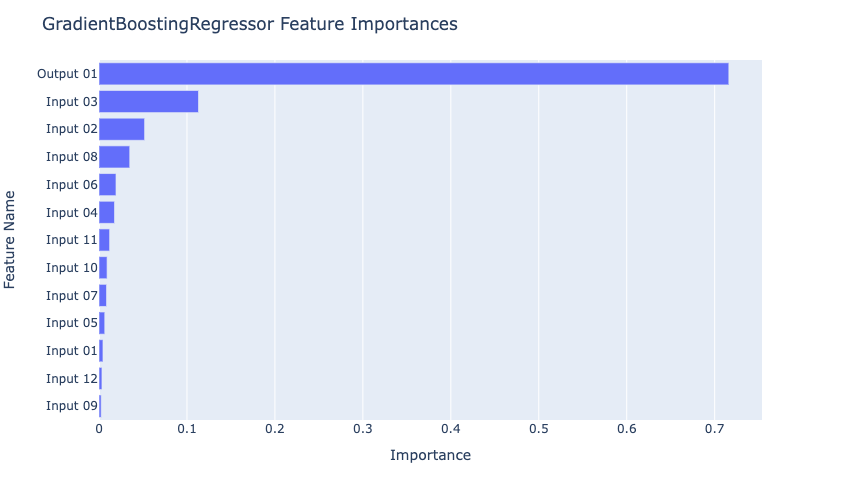

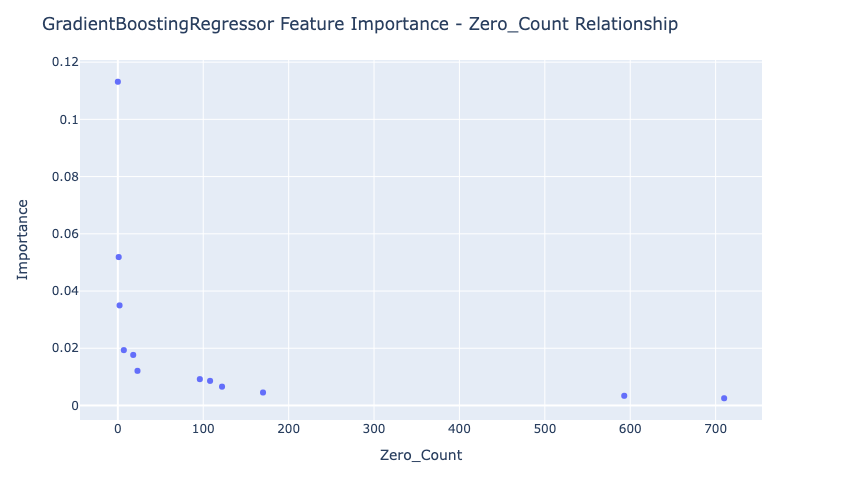

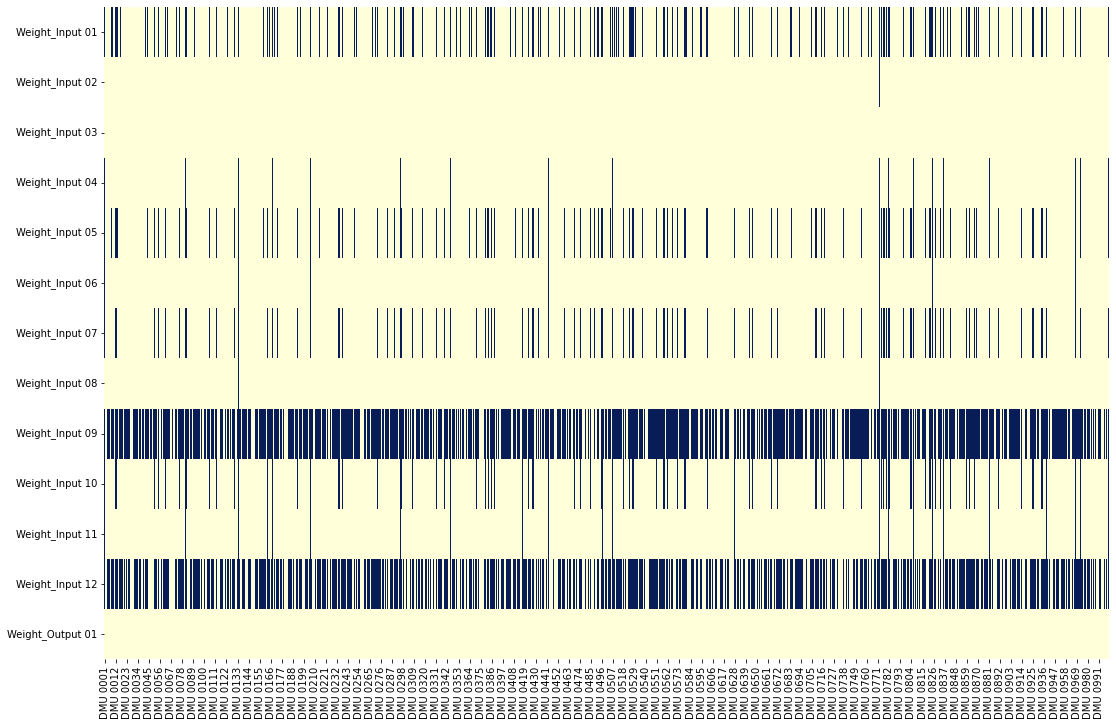

In [81]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_8.xlsx", i=i)
results.append(r)

In [39]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


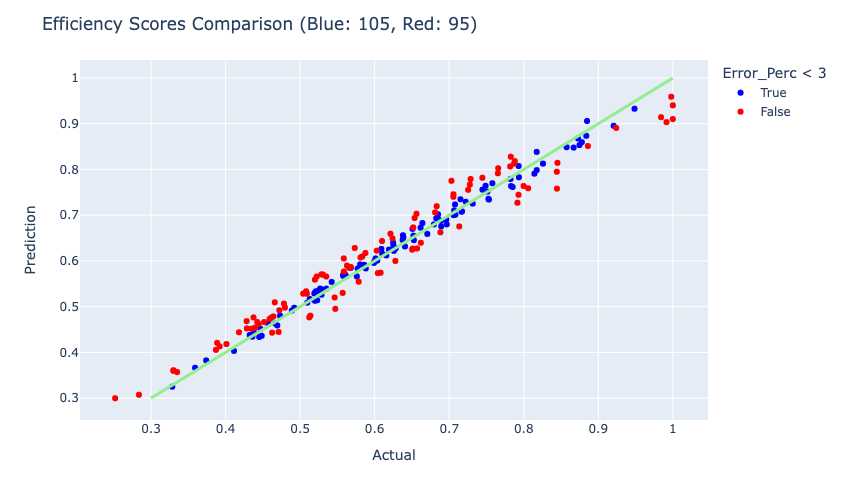

In [83]:
compareML(pipe_gb, y)

blue :  229
red :  771


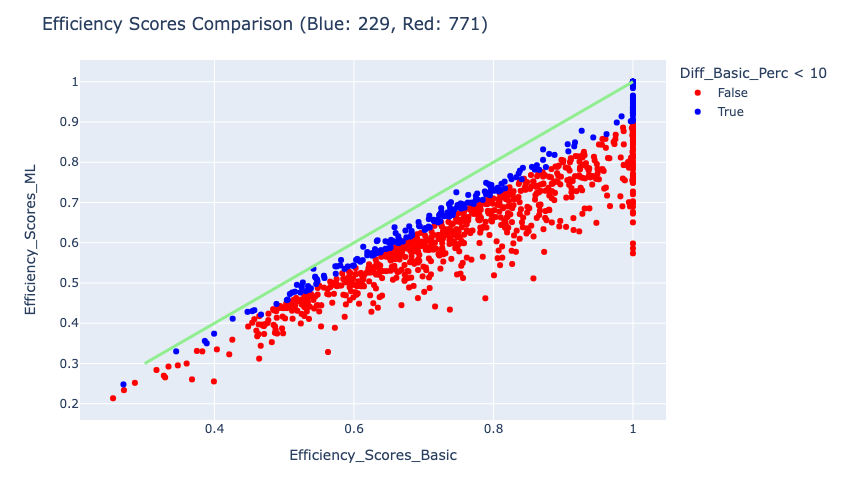

blue :  1000
red :  0


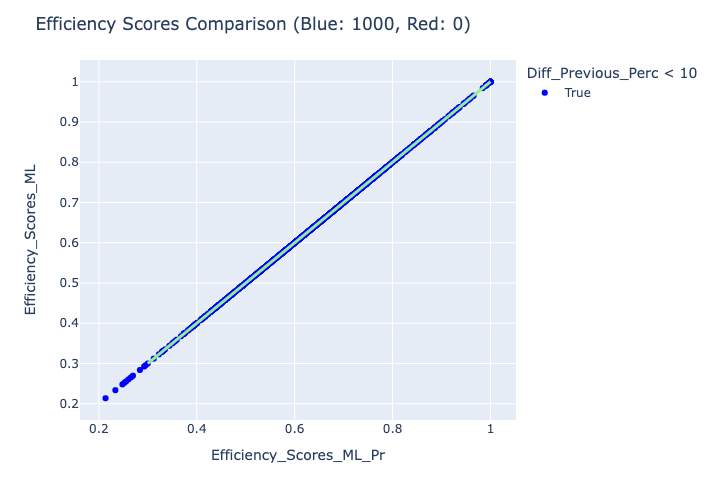

In [84]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_8.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_7.xlsx")

### i = 9

In [40]:
i +=1

In [41]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

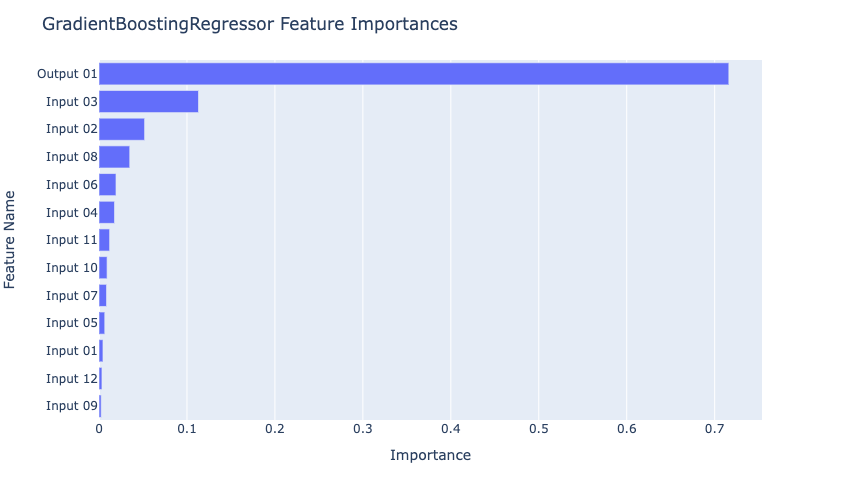

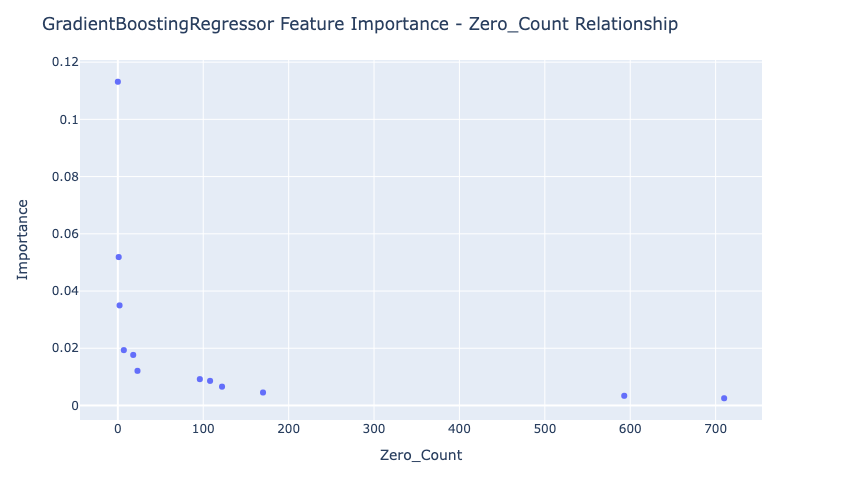

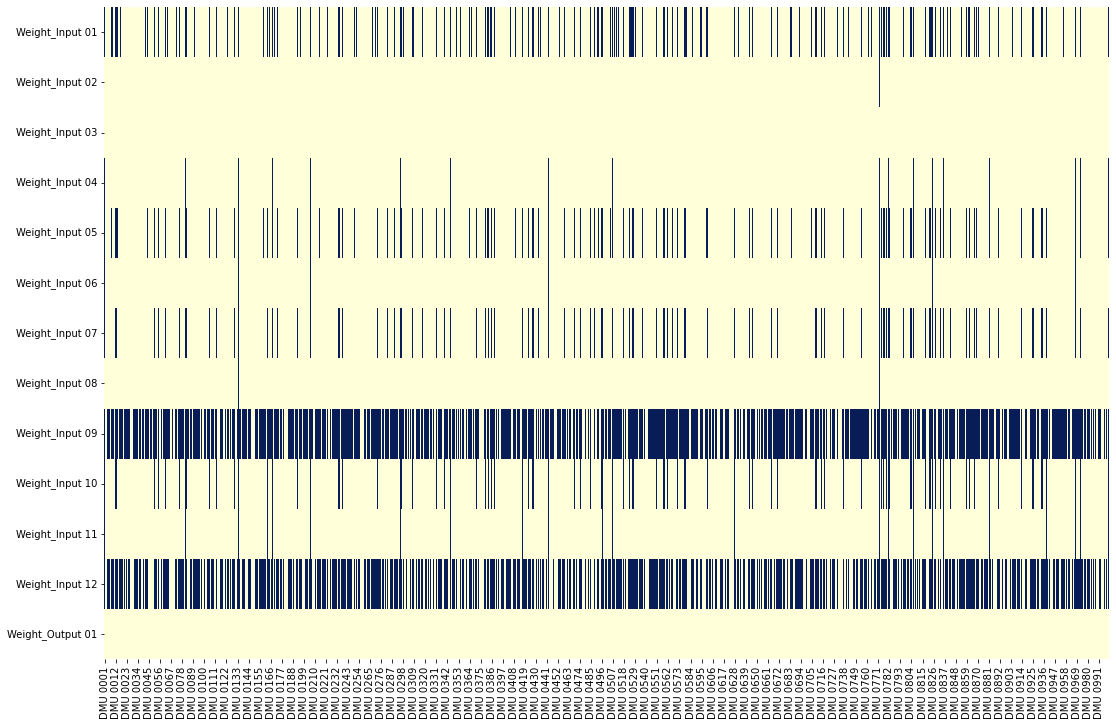

In [87]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_9.xlsx", i=i)
results.append(r)

In [42]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


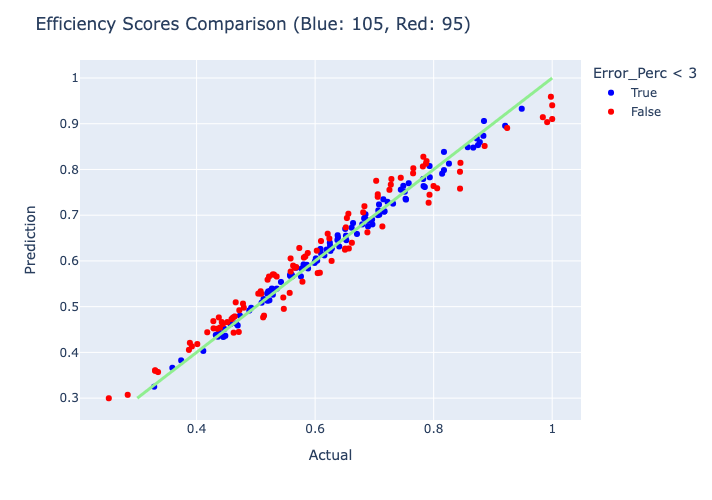

In [89]:
compareML(pipe_gb, y)

blue :  229
red :  771


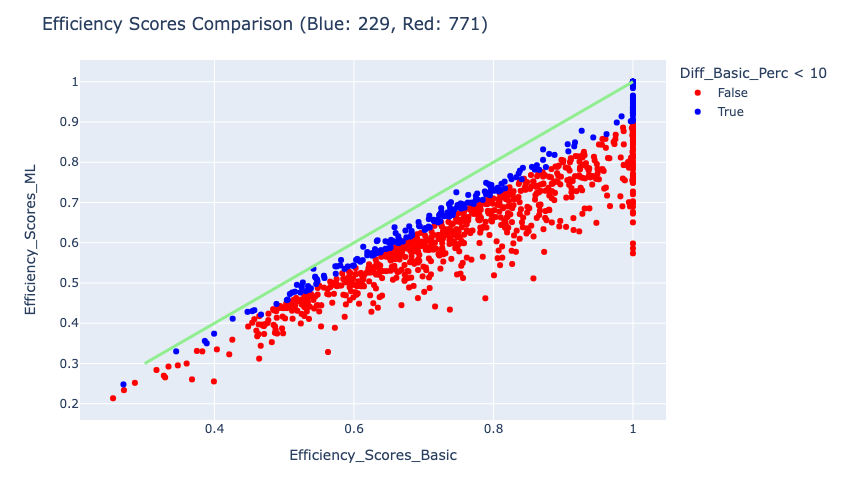

blue :  1000
red :  0


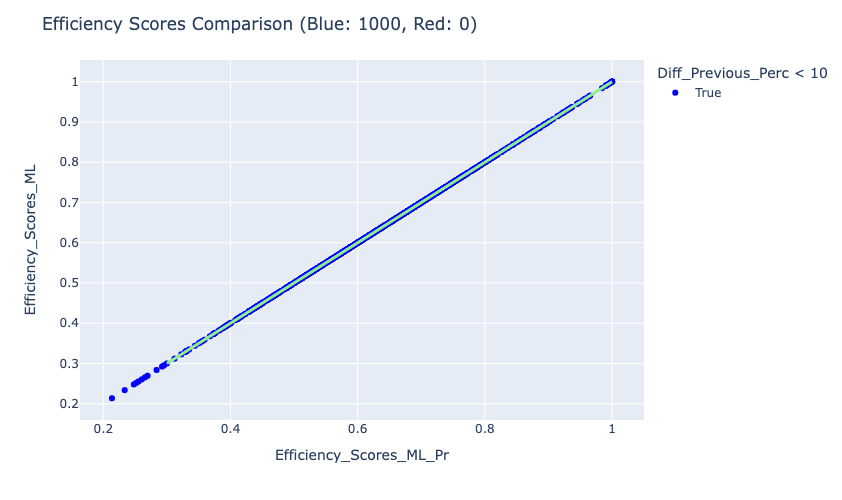

In [90]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_9.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_8.xlsx")

### i = 10

In [43]:
i +=1

In [44]:
#for r in results[-1:]:
#    deasolver(inputfile="Data/US12I1O_1.xlsx", folder = "Data/Data12_1/", out_suffix1="_Sol_", out_suffix2=str(i), input_imp = r)

df_zero: 
 Weight_Input 01     170
Weight_Input 02       1
Weight_Input 03       0
Weight_Input 04      18
Weight_Input 05     122
Weight_Input 06       7
Weight_Input 07     108
Weight_Input 08       2
Weight_Input 09     710
Weight_Input 10      96
Weight_Input 11      23
Weight_Input 12     593
Weight_Output 01      0
dtype: int64
Total Zeros:  1850
neg_mean_squared_error: -0.000991348797557792
neg_root_mean_squared_error: -0.031367738101381416
r2: 0.9519192060705197
grid.best_score:  -0.024534117547569057
grid.best_params:  {'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
grid.best_estimator:  Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, 

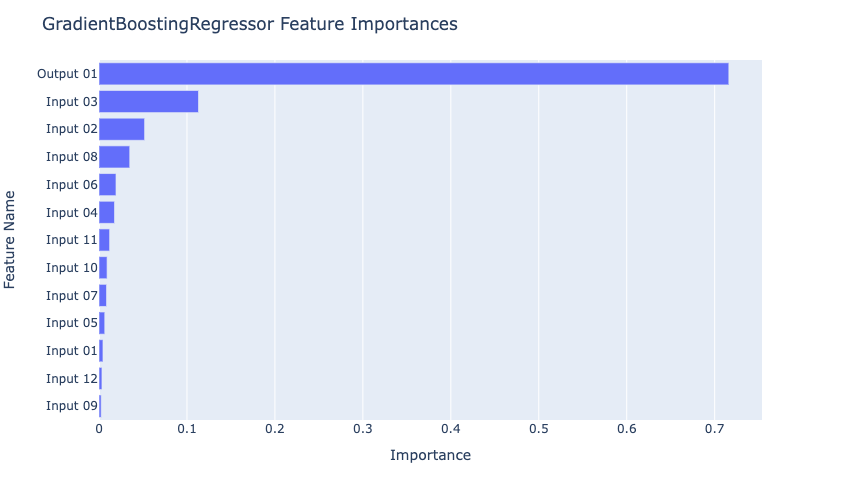

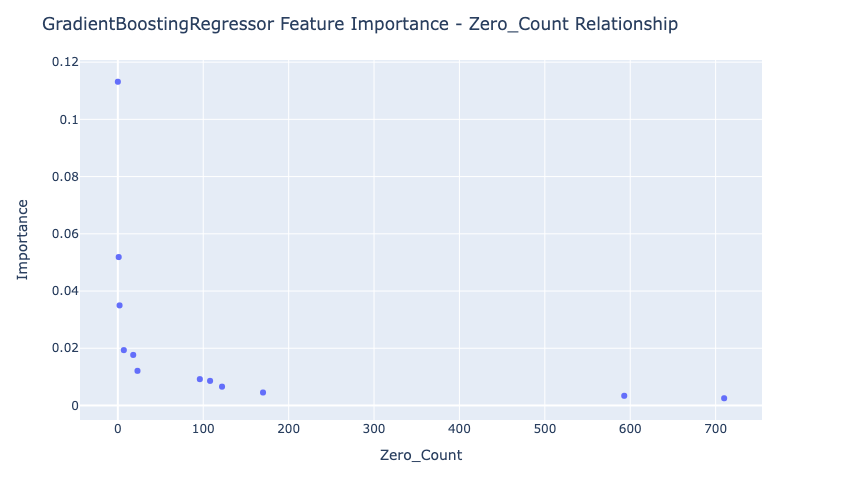

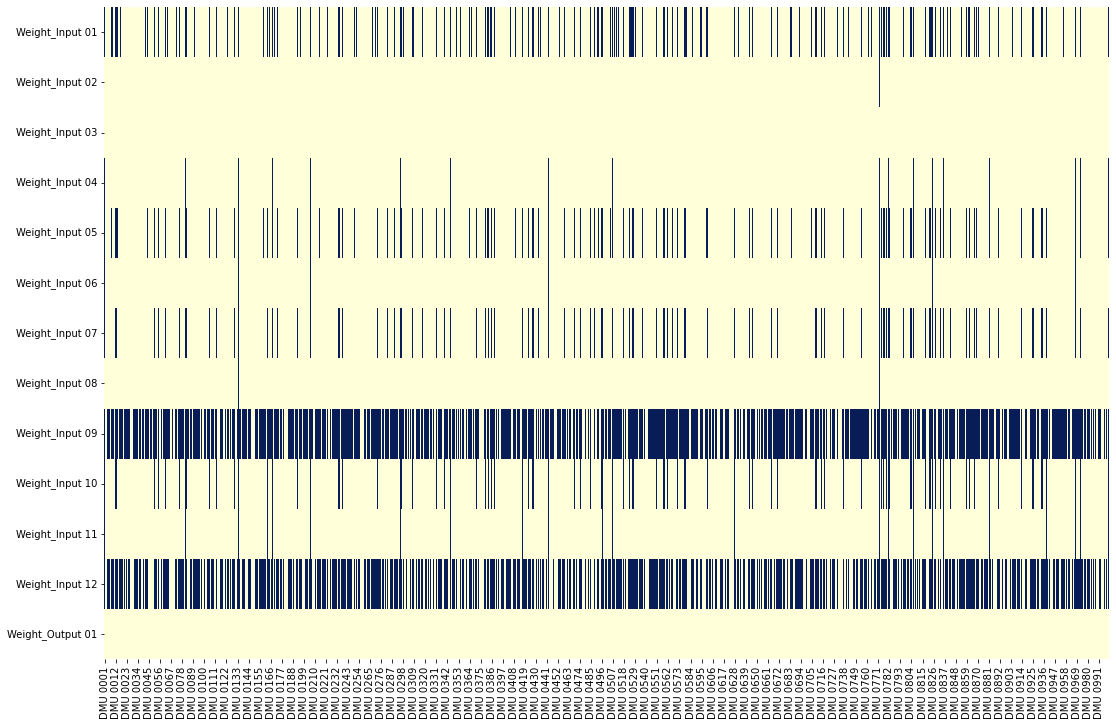

In [93]:
pipe_gb, r, y, df_merged = ml(sol_filepath="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_10.xlsx", i=i)
results.append(r)

In [45]:
df_imp = pd.concat([df_imp, df_merged], ignore_index=True)

res:       Prediction  Actual    Diff  Error_Perc  Error_Perc < 3
0        0.7019  0.6850  0.0169      2.4685            True
1        0.7558  0.7446  0.0112      1.5068            True
2        0.6007  0.6035 -0.0028     -0.4649            True
3        0.7358  0.7526 -0.0169     -2.2432            True
4        0.6272  0.6569 -0.0297     -4.5234           False
..          ...     ...     ...         ...             ...
195      0.4131  0.3921  0.0210      5.3512           False
196      0.6590  0.6706 -0.0116     -1.7309            True
197      0.5167  0.5130  0.0037      0.7240            True
198      0.5395  0.5270  0.0125      2.3726            True
199      0.6754  0.7135 -0.0381     -5.3393           False

[200 rows x 5 columns]
blue:  105
red:  95
rho: 0.9872
p-Value 0.0


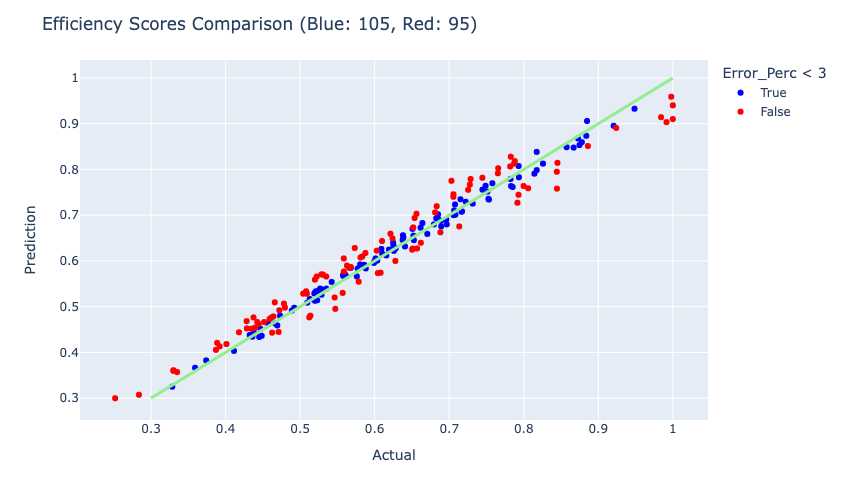

In [95]:
compareML(pipe_gb, y)

blue :  229
red :  771


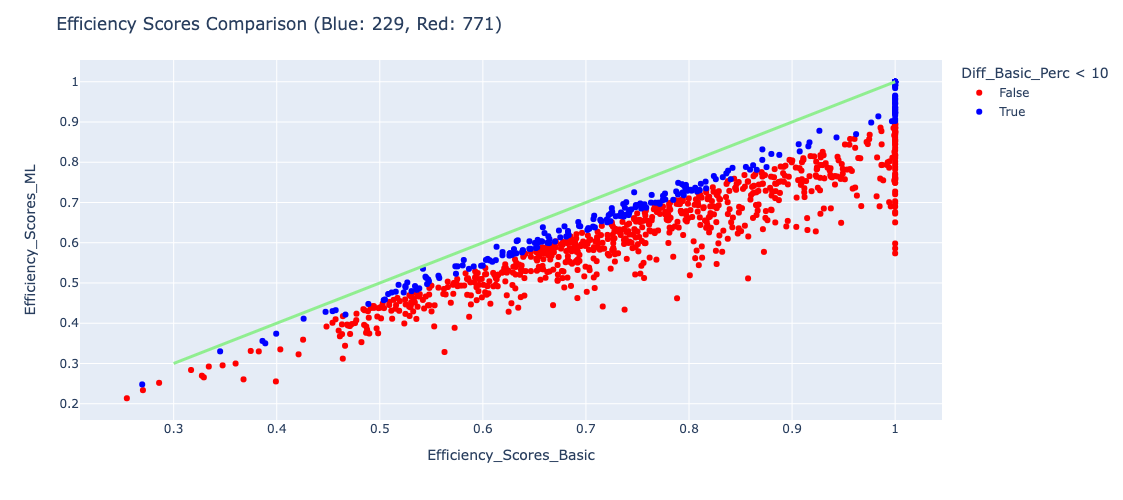

blue :  1000
red :  0


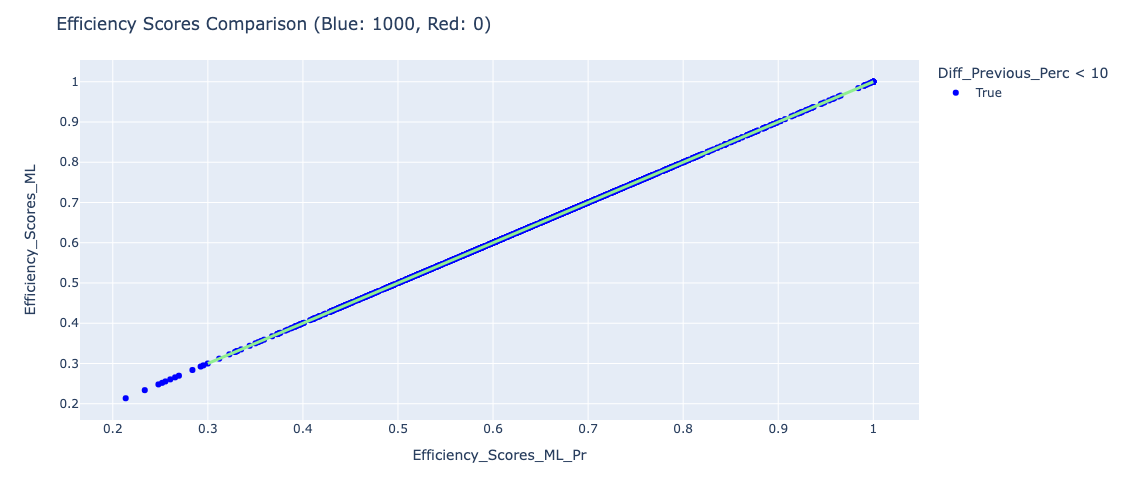

In [59]:
compareES(df_1_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_10.xlsx", df_0_path="Data/Data12_1/US12I1O_1_gradientboostingregressor_Sol_9.xlsx")

In [100]:
#with open('Data/Data12_1/GB_result_12I1O_1.pkl', 'wb') as f:
#    pickle.dump(results, f)

In [101]:
with open('Data/Data12_1/GB_result_12I1O_1.pkl', 'rb') as f:
    r = pickle.load(f)

In [105]:
#df_imp.to_pickle('Data/Data12_1/GB_12I1O_1_df_imp.pkl')